Copied from: 
`scrape_pubmed_by_year.ipynb`

* + Edited to add in patents (generated seperately), and output less files, and also target cleaning (min 4 (?) previous occurences

----------------------------
* https://esperr.github.io/pubmed-by-year/?q1=LBD%20NOT%20(review[Publication%20Type])&q2=LBD&q3=LBD%20AND%20(review[Publication%20Type])
CSV download link example: has the actual data in it's url.. 

* https://esperr.github.io/pubmed-by-year/?q1=(PINK1)%20NOT%20(review[Publication%20Type])&q2=(ncRNA)%20AND%20(review[Publication%20Type])&q3=(ncRNA)%20NOT%20(review[Publication%20Type])&q4=(PINK1)%20AND%20(review[Publication%20Type])&q5=(microRNA,miRNA)%20AND%20(review[Publication%20Type])&q6=(microRNA,miRNA)%20NOT%20(review[Publication%20Type])&startyear=1980&endyear=2020#!

* https://esperr.github.io/pubmed-by-year/?q1=(sleep)%20AND%20(review[Publication%20Type])&q2=(sleep)%20NOT%20(review[Publication%20Type])&q3=antibiotic%20AND%20(review[Publication%20Type])&q4=antibiotic%20NOT%20(review[Publication%20Type])&q5=antibiotic%20NOT%20(review[Publication%20Type])&q6=antibiotic%20resistant&startyear=1945


Another (formatting broken):
* esperr.github.io/pubmed-by-year/?q1=(ncRNA) AND (review[Publication Type])&q2=(PINK1) AND (review[Publication Type])&q3=(ncRNA) NOT (review[Publication Type])&q4=(PINK1) NOT (review[Publication Type])&q5=(microRNA,miRNA) AND (review[Publication Type])&q6=(microRNA,miRNA) NOT (review[Publication Type])&startyear=1980&endyear=2020


--------------------
* **MeSH** headings [MH] - https://www.nlm.nih.gov/bsd/disted/meshtutorial/searchingpubmedusingmeshtags/index.html
    MeSH headings can be qualified using two search field tags:

                            [mh]     to search a MeSH heading
                            [majr]   to search a MeSH heading that is a major topic of an article

    Examples:

    eye [mh]
    eye [majr]
    
    "Psychiatry/ethics"[MAJR]
    
    * https://pubmed.ncbi.nlm.nih.gov/?term=%22Amino+Acids%2C+Peptides%2C+and+Proteins%22%5BMAJR%5D - `"Amino Acids, Peptides, and Proteins"[MAJR]`
    
* List of mesh major subheadings/high level:
    * https://www.nlm.nih.gov/mesh/subhierarchy.html
    * https://meshb-prev.nlm.nih.gov/treeView
    
* Quick DL list of MEsh terms TRee easily: https://raw.githubusercontent.com/dhimmel/mesh/gh-pages/data/tree-numbers.tsv
* Major topic: `[MeSH Major Topic]`


* https://esperr.github.io/pubmed-by-year/?q1=Amino%20Acids,%20Peptides,%20and%20Proteins[MAJR]&q2=Amino%20Acids,%20Peptides,%20and%20Proteins[mesh]
* Topic vs major topic "decorrolates" after a certain date.. 
-------------------------------

*Google NGrams
* https://books.google.com/ngrams/graph?content=Albert+Einstein%2CSherlock+Holmes%2CFrankenstein&year_start=1930&year_end=2019&corpus=26&smoothing=3

* Ngrams api/packages:
    * https://stackoverflow.com/questions/67753096/how-i-get-the-occurrence-of-a-sentence-with-google-ngram-viewer-and-python
    * https://jameshfisher.com/2018/11/25/google-ngram-api/
    * https://gitlab.com/cpbl/google-ngrams

-----------------------------------
Could add:
* Mesh terms TS
* Mesh categories/distrib per search term - https://esperr.github.io/mesh-cat-graph/ - not downloadable/machine readable format figure


* CRISPR - example of many reviews, early on . 
* Time to/from peak of papers vs reviews starting ? (of reviews)


MIN 3 years of papers

~ 3 classes. 


Consider taking from ~ 1980s+ data (better annotation?)

* Human genetics, plant, animal husbandry genetics - one method appearing decades before in each field (under another name). 
    * word2vec between domains?  
    * qtl, eqtl, 


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn

import functools
import logging
import json
from bs4 import BeautifulSoup
import urllib
import re
from sklearn.model_selection import cross_val_predict ## time split? 
from sklearn.linear_model import LinearRegression
import urllib.request
# import time
# localtime = time.asctime( time.localtime(time.time()) )
# import urllib2
import csv
import sys
from sklearn.metrics import roc_auc_score, classification_report

pd.options.mode.use_inf_as_na = True

In [3]:
SAVE_OUTPUT = True#False

In [4]:
def get_pubmed_year_terms_url(terms_list:[],get_reviews=False,
                              get_mesh=False,get_mesh_major=True,max_len=60):
    """
    Generate URLs from a given list of terms for downloading
    (manually) from https://esperr.github.io/pubmed-by-year
    
    Max length supported seems to be maybe 77? I set to 60 for safety
    """
    q = 1
    url = "https://esperr.github.io/pubmed-by-year/?"
    suffix=""
    if get_reviews:
        suffix+="%20AND%20(review[Publication%20Type])"
    if get_mesh:
        suffix+="[mh]"   
        if get_mesh_major:
            suffix="[majr]" # overwrites just mesh
        
    terms_list = list(set(terms_list)) # deduplicate
    ## handle long cases - recursion
    while len(terms_list)>max_len:
        get_pubmed_year_terms_url(terms_list[0:max_len],get_reviews,
                              get_mesh,get_mesh_major,max_len)
        terms_list = terms_list[max_len:]
        
    for index, term in enumerate(terms_list):
        term = term.replace(" ","%20") # for spaces
        url = url+f"q{q}={term}"+suffix
        q +=1
        if index<len(terms_list)-1: ## +1? 0 index?
            url = url+"&"

    print(url)
    print()

In [5]:
clf = LinearRegression()

#### MESH high level terms
* example: `https://esperr.github.io/pubmed-by-year/?q1=Health%20Care%20Facilities,%20Manpower,%20and%20Services[Mesh]` = "Health Care Facilities, Manpower, and Services[Mesh"]

* list: https://www.nlm.nih.gov/mesh/subhierarchy.html
*  16 top level cats: https://esperr.github.io/mesh-cat-graph/
    * https://www.nlm.nih.gov/bsd/disted/meshtutorial/meshtreestructures/index.html
* Could add # terms as major topic, vs non major topic (for some cases, there is a clear change/discontinuity!) ; e.g. `Amino Acids, Peptides, and Proteins	` : https://esperr.github.io/pubmed-by-year/?q1=Amino%20Acids,%20Peptides,%20and%20Proteins[mh]&q2=Amino%20Acids,%20Peptides,%20and%20Proteins[majr]


* https://www.nlm.nih.gov/bsd/disted/meshtutorial/searchingpubmedusingmeshtags/index.html
    ```
    [mh]     to search a MeSH heading
    [majr]   to search a MeSH heading that is a major topic of an article
    ```

In [6]:
### what about 16 top level cats? https://esperr.github.io/mesh-cat-graph/
mesh_cat = pd.read_csv("https://raw.githubusercontent.com/dhimmel/mesh/gh-pages/data/tree-numbers.tsv",sep="\t")
# mesh_cat = mesh_cat["mesh_tree_number"].str.split(".",expand=True)[0].drop_duplicates() ## 117 terms! a lot at the second level
mesh_cat = mesh_cat.loc[mesh_cat["mesh_tree_number"].str.len()<4]
## warning, unsuited, as pubmed by year needs name, not category term.

## D03[MeSH Major Topic] -> no results 
### should we do something about commas, etc'? Drop or clean? 

# mesh_cat["mesh_tree_number"].str.split("[A-Z]",regex=True,expand=True)[1].astype(int)
# mesh_cat["mesh_tree_number"].str.extract("([A-Za-z])(d+)",expand=True)

mesh_cat["num"] = mesh_cat["mesh_tree_number"].str.replace("[A-Z]","").astype(int)
mesh_cat.sort_values(["num"])

/var/folders/hl/bb0z87yd5pzfcp81jc8662kr0000gn/T/ipykernel_37258/1562384813.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  mesh_cat["num"] = mesh_cat["mesh_tree_number"].str.replace("[A-Z]","").astype(int)


,mesh_id,mesh_name,mesh_tree_number,num
25542,D013676,"Technology, Industry, and Agriculture",J01,1
10702,D005842,Geographic Locations,Z01,1
7216,D003933,Diagnosis,E01,1
47609,D052181,Publication Components,V01,1
12507,D006809,Humanities,K01,1
...,...,...,...,...
3044,D001697,Biomedical and Dental Materials,D25,25
55430,D064419,Chemically-Induced Disorders,C25,25
7937,D004364,Pharmaceutical Preparations,D26,26
27987,D014947,Wounds and Injuries,C26,26


### Terms list
* For each term - also +- review type (as secondary)

* note that e.g. "super resolution microscopy" has 2 cases of appearing in literature decades before it really did (false positives) - we'll want to filter for multiple occurences in dates as start point

Get preds on test set , e.g. CRISPR - look at peaks/prediction

* pcr,

* cases of decoupling? like AA

Debias by year (linear)


Patents (and crispr?)  .  e.g. # pred patents


* mesh - some terms split incorrectly ("hereditary" "and neonatal"

In [7]:
TERMS_LIST = list(set([
    "miRNA","prion","rnase","ncRNA","lncRNA","PCR","mass spectrometry",
    "ancient dna", "carbon dating", ## ancient dna - methods changed over time, C14.. 
    "sleep","coral","SNP","GWAS",
    "neural networks","artificial neural networks","machine learning","genetic algorithm",
    "antibiotic","antibiotic resistance","viral therapy","gene therapy",
    "microglia","junk dna",
    "eugenics","genetic engineering","vitamin D","vitamin C","race","ethnic differences",
    "influenza", "archaea","stem cells", "vaccine","Epidemiology",
    "Synthetic Biology","epigenetics","perceptron","eugenics","lithium","lipid",
    "Mononucleosis","epstein-barr","multiple sclerosis","autoimmune",
    "ribosome","ribozyme",
    "zebra fish","mouse","rnai","CRISPR","DNA array","RNA","NGS","single cell",
    "illumina","nanopore","BRCA1","BRCA2","cholesterol", "soy milk",
    "cumin","biosimilar","homeopathy","natural medicine","single cell","FACS",
    "Drug repurposing","LSD","cannabis","cannabidiol","MRI","fMRI","EEG","BLAST","HMM", ## profile-profile, homology,   
        "connectome","metabolome","metagenomics",
    "autism", "savant", "autoimmune" , "inflammatory",
    ### https://en.wikipedia.org/wiki/Neurotransmitter
    "glutamate", "GABA", "acetylcholine", "glycine" , "serotonin", "epinephrine", "Norepinephrine",
    "dopamine", "substance P", "opioids", "cocaine", "Histamine", "neuropeptide", "neutrotransmitter",
    ## some brain regions: + https://en.wikipedia.org/wiki/List_of_regions_in_the_human_brain
    "amygdala", "hippocampus", "neocortex", "basal ganglia", "lateral ventricles",
    "thalamus", "hypothalamus",
    "subthalamus", "pituitary gland","pineal gland" ,"cerebellum", "Medulla oblongata",
    "paleocortex" , "neocortex", "Brodmann area", "Prefrontal cortex", "Orbitofrontal cortex",
    "Dorsolateral prefrontal cortex", "somatosensory cortex", "Insular cortex", "Cingulate cortex",
    ### combine cannabis, canabidiol =  marijuana .  lsd.  
    ## psychiatric drugs, treatment 
]))
### GO subcellular organellas list ; brain regions
### drugs - painkillers, opioids, 
### list of tissues (GTX) = thyroid, skin, etc' 
### medical procedures?? 

print(len(TERMS_LIST), "# terms")
# TERMS_LIST

## more terms added (not counting mesh)  (these were added already in the list in patents)
MORE_TERMS_LIST = ["carbon nanotubes","crispr cas-9", "hydrophonics","aquaphonic agriculture",
"ancient bacteria", "ancient viruses",
"covid","synthetic biology", "buckyballs","ultrasound", "language model", "crypto","blockchain",
    "graph neural network",]

113 # terms


In [8]:
list(mesh_cat["mesh_name"])

['Amino Acids, Peptides, and Proteins',
 'Anesthesia and Analgesia',
 'Animal Diseases',
 'Animal Structures',
 'Archaea',
 'Bacteria',
 'Bacterial Infections and Mycoses',
 'Behavior and Behavior Mechanisms',
 'Mental Disorders',
 'Biological Factors',
 'Biological Phenomena',
 'Biomedical and Dental Materials',
 'Body Regions',
 'Carbohydrates',
 'Cardiovascular Diseases',
 'Cardiovascular System',
 'Cell Physiological Phenomena',
 'Cells',
 'Circulatory and Respiratory Physiological Phenomena',
 'Dentistry',
 'Diagnosis',
 'Digestive System',
 'Digestive System Diseases',
 'Behavioral Disciplines and Activities',
 'Pharmaceutical Preparations',
 'Health Care Economics and Organizations',
 'Education',
 'Embryonic Structures',
 'Endocrine System Diseases',
 'Endocrine System',
 'Environment and Public Health',
 'Equipment and Supplies',
 'Eye Diseases',
 'Health Care Facilities, Manpower, and Services',
 'Female Urogenital Diseases and Pregnancy Complications',
 'Fluids and Secretion

#### get total Medline papers/citations per year
* MEDLINE - not all papers, only mesh containing, but a decent proxy.
* "MEDLINE consists of completed citations indexed with MeSH"
* pd.read_html("https://www.nlm.nih.gov/bsd/medline_cit_counts_yr_pub.html")

In [9]:
df_medline = pd.read_html("https://www.nlm.nih.gov/bsd/medline_cit_counts_yr_pub.html")[0].drop(columns="# Citations Published in US")
print(df_medline.columns)
# df_medline

df_medline['Year of Publication'] = df_medline['Year of Publication'].str.replace("*","",regex=False)
df_medline['%s Citations Published in US'] = df_medline['%s Citations Published in US'].str.replace("%","",regex=False)
df_medline['Year of Publication'] = pd.to_numeric(df_medline['Year of Publication'],errors="coerce")
df_medline.dropna(subset=['Year of Publication'],axis=0,inplace=True)
df_medline['Year of Publication'] = df_medline['Year of Publication'].astype(int).astype("str")
df_medline.columns = ["Year","Total Medline Cites","% US Citations"]
df_medline['% US Citations'] = pd.to_numeric(df_medline['% US Citations'],errors="coerce")
df_medline["Year"] = pd.to_datetime(df_medline["Year"])

df_medline.to_csv("medline_total.csv.gz",index=False,compression="gzip")
df_medline

Index(['Year of Publication', 'Total # Citations',
       '%s Citations Published in US'],
      dtype='object')


,Year,Total Medline Cites,% US Citations
0,2021-01-01,774026,35.0
1,2020-01-01,986012,37.0
2,2019-01-01,903184,38.0
3,2018-01-01,866985,40.0
4,2017-01-01,848833,40.0
...,...,...,...
70,1951-01-01,102578,NaN
71,1950-01-01,84099,NaN
72,1949-01-01,60931,NaN
73,1948-01-01,68711,NaN


https://esperr.github.io/pubmed-by-year/?q1=(sleep)%20AND%20(review[Publication%20Type])&q2=(sleep)%20NOT%20(review[Publication%20Type])&q3=antibiotic%20AND%20(review[Publication%20Type])&q4=antibiotic%20NOT%20(review[Publication%20Type])&q5=antibiotic%20NOT%20(review[Publication%20Type])&q6=antibiotic%20resistant&startyear=1945


https://esperr.github.io/pubmed-by-year/?q1=miRNA&q2=ncRNA&q3=miRNA%20AND%20(review[Publication%20Type])

In [13]:
## terms may already exist
# mini_lst = ["RT PCR", "Stem cell", "climate change", 
#             "Immunotherapy", "species conservation", "Restriction Enzymes",
#             "single cell",
# #             "NGS",
#             "Sanger sequencing"
# ]
# mini_lst =#['eugenics', 'soy milk', 'paleocortex', 'influenza', 'somatosensory cortex', 'junk dna', 'ancient dna']
# mini_lst =['Medulla oblongata', 'DNA array', 'influenza', 'neuropeptide',
#        'subthalamus', 'serotonin', 'junk dna', 'eugenics',
#        'pituitary gland']
mini_lst = ['miRNA', 'Drug repurposing', 'nanopore', 'carbon nanotubes',
        'metabolome', 'Mononucleosis', 'illumina',
       'Synthetic Biology', 'NGS', 'connectome', 'lithium', 'cannabidiol',
       'natural medicine', 'graph neural network', 'biosimilar', 'cumin',
       'lncRNA', 'CRISPR', 'machine learning']
get_pubmed_year_terms_url(terms_list=mini_lst,get_reviews=False)

https://esperr.github.io/pubmed-by-year/?q1=CRISPR&q2=illumina&q3=connectome&q4=Mononucleosis&q5=lncRNA&q6=machine%20learning&q7=miRNA&q8=Drug%20repurposing&q9=biosimilar&q10=Synthetic%20Biology&q11=graph%20neural%20network&q12=cumin&q13=lithium&q14=NGS&q15=metabolome&q16=carbon%20nanotubes&q17=cannabidiol&q18=nanopore&q19=natural%20medicine



In [11]:
less_pop_lst = ['Medulla oblongata', 'serotonin', 'DNA array', 'Norepinephrine',  'neuropeptide', 'Histamine', 'influenza', 'junk dna', 'pituitary gland', 'ancient dna', 'hypothalamus',
       'somatosensory cortex', 'acetylcholine', 'cocaine', 'ribozyme']
get_pubmed_year_terms_url(terms_list=less_pop_lst,get_reviews=False)

https://esperr.github.io/pubmed-by-year/?q1=Medulla%20oblongata&q2=influenza&q3=hypothalamus&q4=Norepinephrine&q5=serotonin&q6=cocaine&q7=ancient%20dna&q8=somatosensory%20cortex&q9=junk%20dna&q10=Histamine&q11=pituitary%20gland&q12=acetylcholine&q13=ribozyme&q14=neuropeptide&q15=DNA%20array



In [14]:
flip_terms_lst = ['eugenics' , 'cerebellum' , 'Mononucleosis' , 'hippocampus' , 'MRI' , 'amygdala',
 'antibiotic' , 'Norepinephrine' , 'viral therapy' , 'genetic algorithm',
 'ancient viruses' , 'zebra fish' , 'carbon dating' , 'neocortex',
 'carbon nanotubes' , 'HMM' , 'savant']
get_pubmed_year_terms_url(terms_list=flip_terms_lst,get_reviews=False)

https://esperr.github.io/pubmed-by-year/?q1=Mononucleosis&q2=antibiotic&q3=Norepinephrine&q4=HMM&q5=MRI&q6=carbon%20dating&q7=ancient%20viruses&q8=savant&q9=eugenics&q10=hippocampus&q11=cerebellum&q12=carbon%20nanotubes&q13=zebra%20fish&q14=neocortex



In [9]:
# get_pubmed_year_terms_url(terms_list=['epigenetics',
#  'antibiotic resistance',
#  'sleep',
#  'vitamin D',
#  'neocortex',
#  'metabolome',
#  'pituitary gland'])
get_pubmed_year_terms_url(terms_list=TERMS_LIST,get_reviews=False)
## save as - a_111_terms_PubMed by Year.csv , b_111_terms_PubMed by Year.csv

https://esperr.github.io/pubmed-by-year/?q1=sleep&q2=junk%20dna&q3=Drug%20repurposing&q4=MRI&q5=soy%20milk&q6=coral&q7=cannabidiol&q8=PCR&q9=viral%20therapy&q10=Synthetic%20Biology&q11=antibiotic%20resistance&q12=vitamin%20C&q13=SNP&q14=savant&q15=BRCA2&q16=nanopore&q17=Mononucleosis&q18=Histamine&q19=perceptron&q20=GWAS&q21=rnase&q22=thalamus&q23=Insular%20cortex&q24=metagenomics&q25=GABA&q26=cannabis&q27=Orbitofrontal%20cortex&q28=metabolome&q29=epigenetics&q30=ancient%20dna&q31=ribozyme&q32=epinephrine&q33=Brodmann%20area&q34=BLAST&q35=neural%20networks&q36=neocortex&q37=illumina&q38=FACS&q39=prion&q40=lithium&q41=lncRNA&q42=carbon%20dating&q43=vaccine&q44=artificial%20neural%20networks&q45=serotonin&q46=epstein-barr&q47=hippocampus&q48=machine%20learning&q49=cumin&q50=fMRI&q51=cholesterol&q52=genetic%20algorithm&q53=LSD&q54=miRNA&q55=archaea&q56=DNA%20array&q57=connectome&q58=hypothalamus&q59=RNA&q60=neuropeptide

https://esperr.github.io/pubmed-by-year/?q1=CRISPR&q2=glutamate&q3=r

In [10]:
get_pubmed_year_terms_url(terms_list=TERMS_LIST,get_reviews=True)

https://esperr.github.io/pubmed-by-year/?q1=sleep%20AND%20(review[Publication%20Type])&q2=junk%20dna%20AND%20(review[Publication%20Type])&q3=Drug%20repurposing%20AND%20(review[Publication%20Type])&q4=MRI%20AND%20(review[Publication%20Type])&q5=soy%20milk%20AND%20(review[Publication%20Type])&q6=coral%20AND%20(review[Publication%20Type])&q7=cannabidiol%20AND%20(review[Publication%20Type])&q8=PCR%20AND%20(review[Publication%20Type])&q9=viral%20therapy%20AND%20(review[Publication%20Type])&q10=Synthetic%20Biology%20AND%20(review[Publication%20Type])&q11=antibiotic%20resistance%20AND%20(review[Publication%20Type])&q12=vitamin%20C%20AND%20(review[Publication%20Type])&q13=SNP%20AND%20(review[Publication%20Type])&q14=savant%20AND%20(review[Publication%20Type])&q15=BRCA2%20AND%20(review[Publication%20Type])&q16=nanopore%20AND%20(review[Publication%20Type])&q17=Mononucleosis%20AND%20(review[Publication%20Type])&q18=Histamine%20AND%20(review[Publication%20Type])&q19=perceptron%20AND%20(review[Publ

In [11]:
### get MESH terms - global context. ~113 terms
get_pubmed_year_terms_url(terms_list=list(mesh_cat["mesh_name"]),get_reviews=False,get_mesh=True,
    get_mesh_major=True)

https://esperr.github.io/pubmed-by-year/?q1=Body%20Regions[majr]&q2=Skin%20and%20Connective%20Tissue%20Diseases[majr]&q3=Neoplasms[majr]&q4=Heterocyclic%20Compounds[majr]&q5=Respiratory%20System[majr]&q6=Health%20Care%20Quality,%20Access,%20and%20Evaluation[majr]&q7=Stomatognathic%20System[majr]&q8=Nervous%20System[majr]&q9=Humanities[majr]&q10=Immune%20System%20Phenomena[majr]&q11=Inorganic%20Chemicals[majr]&q12=Respiratory%20Tract%20Diseases[majr]&q13=Chemical%20Actions%20and%20Uses[majr]&q14=Mathematical%20Concepts[majr]&q15=Behavior%20and%20Behavior%20Mechanisms[majr]&q16=Environment%20and%20Public%20Health[majr]&q17=Health%20Care%20Facilities,%20Manpower,%20and%20Services[majr]&q18=Sense%20Organs[majr]&q19=Bacterial%20Infections%20and%20Mycoses[majr]&q20=Hemic%20and%20Lymphatic%20Diseases[majr]&q21=Embryonic%20Structures[majr]&q22=Investigative%20Techniques[majr]&q23=Digestive%20System%20Diseases[majr]&q24=Male%20Urogenital%20Diseases[majr]&q25=Physical%20Phenomena[majr]&q26=Healt

* MORE_TERMS_LIST

In [12]:
### more terms
get_pubmed_year_terms_url(terms_list=MORE_TERMS_LIST,get_reviews=False)

https://esperr.github.io/pubmed-by-year/?q1=ancient%20viruses&q2=synthetic%20biology&q3=graph%20neural%20network&q4=covid&q5=hydrophonics&q6=ancient%20bacteria&q7=ultrasound&q8=crypto&q9=crispr%20cas-9&q10=blockchain&q11=aquaphonic%20agriculture&q12=language%20model&q13=buckyballs&q14=carbon%20nanotubes



In [13]:
get_pubmed_year_terms_url(terms_list=MORE_TERMS_LIST,get_reviews=True)

https://esperr.github.io/pubmed-by-year/?q1=ancient%20viruses%20AND%20(review[Publication%20Type])&q2=synthetic%20biology%20AND%20(review[Publication%20Type])&q3=graph%20neural%20network%20AND%20(review[Publication%20Type])&q4=covid%20AND%20(review[Publication%20Type])&q5=hydrophonics%20AND%20(review[Publication%20Type])&q6=ancient%20bacteria%20AND%20(review[Publication%20Type])&q7=ultrasound%20AND%20(review[Publication%20Type])&q8=crypto%20AND%20(review[Publication%20Type])&q9=crispr%20cas-9%20AND%20(review[Publication%20Type])&q10=blockchain%20AND%20(review[Publication%20Type])&q11=aquaphonic%20agriculture%20AND%20(review[Publication%20Type])&q12=language%20model%20AND%20(review[Publication%20Type])&q13=buckyballs%20AND%20(review[Publication%20Type])&q14=carbon%20nanotubes%20AND%20(review[Publication%20Type])



In [14]:
# ## worked, before adding in alts
# q = 1
# urlstem = "https://esperr.github.io/pubmed-by-year/?"
# url = urlstem
# for index, term in enumerate(TERMS_LIST):
#     term = term.replace(" ","%20") # for spaces
#     url = url+f"q{q}={term}"
#     q +=1
#     if index<len(TERMS_LIST)-1: ## +1? 0 index?
#         url = url+"&"

# print(url)        

In [15]:
# ## + +- review
# q = 1
# urlstem = "https://esperr.github.io/pubmed-by-year/?"
# url = urlstem
# for index, term in enumerate(TERMS_LIST):
#     term = term.replace(" ","%20") # for spaces
#     url = url+f"q{q}={term}"+"%20AND%20(review[Publication%20Type])"
#     q +=1
#     if index<len(TERMS_LIST)-1: ## +1? 0 index?
#         url = url+"&"

# print(url)        

#### attempted pubmed scraping of timeine table
* e.g.: https://pubmed.ncbi.nlm.nih.gov/?term=micro%20RNA&timeline=expanded

### all mesh terms

In [16]:
df_mesh = pd.read_csv("a_mesh_majr.csv",parse_dates=["Year"]).set_index("Year")
df_mesh = df_mesh.join(pd.read_csv("b_mesh_majr.csv",parse_dates=["Year"]).set_index("Year"))
print(df_mesh.shape)
assert df_mesh.shape[1]>= len(list(mesh_cat["mesh_name"]))
df_mesh.dropna(how="all",axis=1,inplace=True) ## some missing
print(len(mesh_cat["mesh_name"]) - df_mesh.shape[1],"cols missing") ## wrong answer? 
df_mesh

(77, 129)
4 cols missing


,Embryonic Structures[majr],Digestive System[majr],Bacterial Structures[majr],Information Science[majr],Human Activities[majr],Support of Research[majr],Stomatognathic System[majr],Biological Factors[majr],Heterocyclic Compounds[majr],Cardiovascular Diseases[majr],...,Access,and Evaluation[majr],Reproductive and Urinary Physiological Phenomena[majr],Humanities[majr],Tissues[majr],Genetic Phenomena[majr],Viral Structures[majr],Musculoskeletal System[majr],Plant Structures[majr],Cell Physiological Phenomena[majr]
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,443.621118,3982.840150,4.874957,823.867791,589.869839,4.874957,1579.486179,2296.104909,4445.961098,2846.975089,...,843.367621,887.242237,48.749573,3534.344074,5284.453761,770.243260,1569.736265,2681.226539,4.874957,1496.611905
1946-01-01,684.194912,4867.240228,1.854187,1412.890306,780.612623,7.416747,2516.131425,2677.445672,6200.400504,3923.459171,...,1055.032263,991.989913,81.584217,3361.640584,6767.781651,1420.307053,2321.441816,3686.123266,16.687681,1857.895127
1947-01-01,694.850115,4928.516526,0.000000,1165.257494,699.461952,4.611837,2332.052267,2395.080707,5913.912375,4061.491161,...,974.634896,963.873943,78.401230,2682.551883,6308.993082,1346.656418,2227.517294,2536.510377,21.521906,1938.508839
1948-01-01,583.687833,5141.540766,0.000000,1018.980454,586.514408,0.000000,2151.023927,2361.603799,5549.980921,4426.417174,...,946.902780,1023.220317,137.088910,2196.249134,6221.292593,1376.542250,2121.344885,1883.912546,21.199316,1854.233503
1949-01-01,689.205106,6121.669373,0.000000,1087.129532,651.004361,12.733582,2336.612231,2588.100468,5316.270334,4709.833508,...,1045.745392,982.077484,148.027887,2215.643205,6449.559100,1150.797441,2306.369974,1905.262153,19.100372,2013.497597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,450.322547,1367.006736,179.576476,4718.640499,1720.250548,244.423536,630.896670,5477.389480,4683.262398,6590.379919,...,3250.027243,1761.537789,639.722009,2345.238077,7257.805821,695.743731,3618.619471,4190.808447,63.849414,3591.683000
2018-01-01,439.624461,1355.657378,176.191616,4792.322772,1726.915629,335.143056,597.609858,5274.007315,4572.287608,6527.784177,...,3181.555391,1718.815719,736.943168,2269.312340,7145.903898,667.833846,3625.044029,4165.211408,63.610301,3493.587695
2019-01-01,427.531829,1246.677986,173.766880,4822.882713,1708.778635,333.834002,515.905916,5083.887949,4410.541290,6437.750571,...,3029.847017,1650.004543,924.414247,2267.132506,7110.529364,587.102068,3552.638304,4092.820475,57.638360,3325.705005


### Analyze/eDA
* Add ratio of reviews to non reviews, assume all rows same in order

* note, col order not the same

In [17]:
# df = pd.read_csv("terms_PubMed by Year.csv"#"PubMed by Year - antibiotic.csv"
#                  ,parse_dates=["Year"]).set_index("Year")
df = pd.read_csv("a_terms_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year")
df = df.join(pd.read_csv("b_terms_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
df = df.join(pd.read_csv("more_terms_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
print(df.shape)
assert df.shape[1]>= len(TERMS_LIST)
display(df.describe().round(1))

# df_target_mat = df.copy()
df

(77, 127)


,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,ancient bacteria,graph neural network,ultrasound,hydrophonics,crypto,covid,ancient viruses,aquaphonic agriculture,synthetic biology,carbon nanotubes
count,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,...,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
mean,178.7,429.6,107.7,120.7,5670.4,4416.5,28.4,46.2,96.9,1058.3,...,9.9,4.4,4141.0,8.5,0.7,173.1,3.1,968.9,72.5,41.6
std,103.5,223.7,70.4,178.7,3765.5,2296.6,29.2,26.7,125.7,503.1,...,11.8,10.1,2295.2,10.4,0.7,1080.5,3.6,1158.4,94.7,74.8
min,4.8,0.0,7.3,0.0,416.1,556.8,0.0,8.0,0.0,119.4,...,0.0,0.0,229.6,0.0,0.0,0.0,0.0,60.7,0.0,0.0
25%,106.3,277.1,27.4,0.0,2367.4,2787.8,0.0,21.9,3.7,660.9,...,0.6,0.0,1154.0,0.9,0.2,0.0,0.0,182.0,2.2,0.0
50%,199.1,484.8,140.2,5.8,4363.9,5153.1,24.9,50.7,21.4,1125.9,...,3.3,0.0,5278.6,3.3,0.7,0.0,1.1,336.4,23.0,0.0
75%,258.0,615.2,172.3,223.9,9046.2,6454.8,59.0,67.5,176.9,1478.2,...,19.3,2.8,5699.7,14.7,1.1,0.0,6.7,1464.5,99.7,29.0
max,396.3,740.2,198.6,529.4,12747.2,7170.1,79.3,98.7,353.6,1772.4,...,33.4,60.5,7730.2,36.1,4.9,7731.0,12.1,4674.2,335.0,230.3


,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,ancient bacteria,graph neural network,ultrasound,hydrophonics,crypto,covid,ancient viruses,aquaphonic agriculture,synthetic biology,carbon nanotubes
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,0.000000,34.124701,0.000000,2573.977478,575.244967,0.000000,87.749232,4.874957,121.873934,...,0.000000,0.000000,506.995564,4.874957,4.874957,0.000000,0.000000,336.372057,0.000000,0.000000
1946-01-01,14.833494,1.854187,48.208856,0.000000,2150.856634,610.027442,0.000000,72.313283,1.854187,153.897501,...,0.000000,0.000000,569.235333,1.854187,0.000000,0.000000,0.000000,172.439368,0.000000,0.000000
1947-01-01,6.149116,0.000000,26.133743,0.000000,1251.345119,642.582629,0.000000,50.730208,1.537279,156.802460,...,0.000000,0.000000,573.405073,4.611837,1.537279,0.000000,0.000000,116.833205,0.000000,0.000000
1948-01-01,14.132877,8.479726,39.572056,0.000000,1027.460181,556.835366,0.000000,90.450415,1.413288,141.328773,...,0.000000,0.000000,631.739616,0.000000,0.000000,0.000000,0.000000,132.849047,0.000000,0.000000
1949-01-01,4.775093,1.591698,20.692070,0.000000,865.883551,692.388502,0.000000,98.685258,4.775093,119.377328,...,0.000000,0.000000,611.211919,1.591698,0.000000,0.000000,0.000000,132.110909,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,125.012854,289.778108,147.805253,478.486892,11626.041966,6481.559645,61.700635,10.129955,345.416119,1260.411982,...,32.911317,24.549234,7730.246881,29.689230,1.380894,0.076716,8.055217,3696.117309,319.830488,168.085536
2018-01-01,121.127091,275.322622,146.764420,492.162408,11737.289458,6492.114849,62.347012,8.025599,349.856654,1220.039623,...,30.938625,27.237832,7689.210414,30.346498,1.036222,0.074016,9.103949,4056.068485,327.446113,169.052197
2019-01-01,114.070006,266.187010,140.191825,529.392725,11708.963191,6432.923713,57.283444,9.582732,334.330884,1175.907733,...,32.078118,34.056504,7435.693619,33.279281,1.413133,3.532832,8.902738,4442.042118,334.983166,175.652426


In [18]:
# df_rev = pd.read_csv("reviews_PubMed by Year.csv"#"PubMed by Year - antibiotic.csv"
#                  ,parse_dates=["Year"]).set_index("Year")
df_rev = pd.read_csv("a_reviews_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year")
df_rev = df_rev.join(pd.read_csv("b_reviews_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
df_rev = df_rev.join(pd.read_csv("more_terms_reviews_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
print(df_rev.shape)
assert df_rev.shape[1]>= len(TERMS_LIST)

df_rev

(77, 127)


,metabolome AND (review[Publication Type]),thalamus AND (review[Publication Type]),biosimilar AND (review[Publication Type]),amygdala AND (review[Publication Type]),GWAS AND (review[Publication Type]),cumin AND (review[Publication Type]),rnai AND (review[Publication Type]),metagenomics AND (review[Publication Type]),hippocampus AND (review[Publication Type]),HMM AND (review[Publication Type]),...,ancient viruses AND (review[Publication Type]),covid AND (review[Publication Type]),buckyballs AND (review[Publication Type]),graph neural network AND (review[Publication Type]),crispr cas-9 AND (review[Publication Type]),language model AND (review[Publication Type]),carbon nanotubes AND (review[Publication Type]),hydrophonics AND (review[Publication Type]),synthetic biology AND (review[Publication Type]),aquaphonic agriculture AND (review[Publication Type])
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1946-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1947-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1948-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1949-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,61.623893,13.199638,12.815928,18.955295,44.280182,1.381358,13.046154,21.334299,42.131404,0.537195,...,2.531640,0.000000,8.515515,1.687760,0.306865,47.027126,13.041780,0.153433,54.852194,257.229941
2018-01-01,66.954300,13.598931,12.409954,18.206219,44.140793,0.371555,13.450309,23.705241,40.945416,0.371555,...,2.516539,0.000000,7.179537,0.740158,0.666143,30.938625,14.359075,0.444095,55.807950,277.559431
2019-01-01,65.801429,12.918943,11.641245,16.681053,42.093039,0.709832,14.409590,22.856591,36.982249,0.425899,...,2.826266,0.565253,7.418948,0.918536,0.635910,29.887762,15.403149,0.777223,62.884416,294.638220


In [19]:
df = df.replace(0,np.nan)  ## may not make sense - what about intermediate years with 0? 
# df_rev = df_rev.replace(0,np.nan) 
df

,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,ancient bacteria,graph neural network,ultrasound,hydrophonics,crypto,covid,ancient viruses,aquaphonic agriculture,synthetic biology,carbon nanotubes
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,NaN,34.124701,NaN,2573.977478,575.244967,NaN,87.749232,4.874957,121.873934,...,NaN,NaN,506.995564,4.874957,4.874957,NaN,NaN,336.372057,NaN,NaN
1946-01-01,14.833494,1.854187,48.208856,NaN,2150.856634,610.027442,NaN,72.313283,1.854187,153.897501,...,NaN,NaN,569.235333,1.854187,NaN,NaN,NaN,172.439368,NaN,NaN
1947-01-01,6.149116,NaN,26.133743,NaN,1251.345119,642.582629,NaN,50.730208,1.537279,156.802460,...,NaN,NaN,573.405073,4.611837,1.537279,NaN,NaN,116.833205,NaN,NaN
1948-01-01,14.132877,8.479726,39.572056,NaN,1027.460181,556.835366,NaN,90.450415,1.413288,141.328773,...,NaN,NaN,631.739616,NaN,NaN,NaN,NaN,132.849047,NaN,NaN
1949-01-01,4.775093,1.591698,20.692070,NaN,865.883551,692.388502,NaN,98.685258,4.775093,119.377328,...,NaN,NaN,611.211919,1.591698,NaN,NaN,NaN,132.110909,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,125.012854,289.778108,147.805253,478.486892,11626.041966,6481.559645,61.700635,10.129955,345.416119,1260.411982,...,32.911317,24.549234,7730.246881,29.689230,1.380894,0.076716,8.055217,3696.117309,319.830488,168.085536
2018-01-01,121.127091,275.322622,146.764420,492.162408,11737.289458,6492.114849,62.347012,8.025599,349.856654,1220.039623,...,30.938625,27.237832,7689.210414,30.346498,1.036222,0.074016,9.103949,4056.068485,327.446113,169.052197
2019-01-01,114.070006,266.187010,140.191825,529.392725,11708.963191,6432.923713,57.283444,9.582732,334.330884,1175.907733,...,32.078118,34.056504,7435.693619,33.279281,1.413133,3.532832,8.902738,4442.042118,334.983166,175.652426


###### Get patents
* Scraped from uspto, patent view. Seems to have much lower coverage than with google search for those keywords.
* Raw counts 

* Includes KWs/terms AND the mesh

In [20]:
df_patents = pd.read_csv("patentsview_terms.csv",parse_dates=["year"])
df_patents = df_patents.rename(columns={"year":"Year","term":"variable"})#.set_index("Year")
print(df_patents["variable"].nunique(),"# unique terms/variables")

### this can double count patents, and patent_frac is not the frac out of all patents that year! 
df_patents["patent_yearly_total"] = df_patents.groupby(["Year"])["patent_count"].transform("sum")
df_patents["patent_frac"] = 100*df_patents["patent_count"].div(df_patents["patent_yearly_total"])
df_patents

210 # unique terms/variables


,variable,Year,patent_count,patent_yearly_total,patent_frac
0,"Amino Acids, Peptides, and Proteins",1976-01-01,5,2936,0.170300
1,"Amino Acids, Peptides, and Proteins",1977-01-01,1,2674,0.037397
2,"Amino Acids, Peptides, and Proteins",1984-01-01,1,2445,0.040900
3,"Amino Acids, Peptides, and Proteins",1986-01-01,2,2608,0.076687
4,"Amino Acids, Peptides, and Proteins",1988-01-01,1,3082,0.032446
...,...,...,...,...,...
5648,zebra fish,2012-01-01,1,16562,0.006038
5649,zebra fish,2013-01-01,1,18098,0.005525
5650,zebra fish,2017-01-01,1,21165,0.004725
5651,zebra fish,2018-01-01,1,20638,0.004845


In [21]:
df_patents.loc[df_patents["patent_yearly_total"].isna()]

,variable,Year,patent_count,patent_yearly_total,patent_frac


### get ratio, diff of reviews to papers
###  reshape rev numbers? 

In [22]:
(.1-.05)/.1

0.5

In [23]:
df_rev

,metabolome AND (review[Publication Type]),thalamus AND (review[Publication Type]),biosimilar AND (review[Publication Type]),amygdala AND (review[Publication Type]),GWAS AND (review[Publication Type]),cumin AND (review[Publication Type]),rnai AND (review[Publication Type]),metagenomics AND (review[Publication Type]),hippocampus AND (review[Publication Type]),HMM AND (review[Publication Type]),...,ancient viruses AND (review[Publication Type]),covid AND (review[Publication Type]),buckyballs AND (review[Publication Type]),graph neural network AND (review[Publication Type]),crispr cas-9 AND (review[Publication Type]),language model AND (review[Publication Type]),carbon nanotubes AND (review[Publication Type]),hydrophonics AND (review[Publication Type]),synthetic biology AND (review[Publication Type]),aquaphonic agriculture AND (review[Publication Type])
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1946-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1947-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1948-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1949-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,61.623893,13.199638,12.815928,18.955295,44.280182,1.381358,13.046154,21.334299,42.131404,0.537195,...,2.531640,0.000000,8.515515,1.687760,0.306865,47.027126,13.041780,0.153433,54.852194,257.229941
2018-01-01,66.954300,13.598931,12.409954,18.206219,44.140793,0.371555,13.450309,23.705241,40.945416,0.371555,...,2.516539,0.000000,7.179537,0.740158,0.666143,30.938625,14.359075,0.444095,55.807950,277.559431
2019-01-01,65.801429,12.918943,11.641245,16.681053,42.093039,0.709832,14.409590,22.856591,36.982249,0.425899,...,2.826266,0.565253,7.418948,0.918536,0.635910,29.887762,15.403149,0.777223,62.884416,294.638220


In [24]:
df.values

array([[1.46248720e+01,            nan, 3.41247014e+01, ...,
        3.36372057e+02,            nan,            nan],
       [1.48334940e+01, 1.85418675e+00, 4.82088556e+01, ...,
        1.72439368e+02,            nan,            nan],
       [6.14911606e+00,            nan, 2.61337433e+01, ...,
        1.16833205e+02,            nan,            nan],
       ...,
       [1.14070006e+02, 2.66187010e+02, 1.40191825e+02, ...,
        4.44204212e+03, 3.34983166e+02, 1.75652426e+02],
       [1.06328908e+02, 2.30317768e+02, 1.38079902e+02, ...,
        4.52129695e+03, 3.31592803e+02, 1.54682072e+02],
       [9.09052219e+01, 2.07345619e+02, 1.47366330e+02, ...,
        4.67421338e+03, 3.31537669e+02, 1.46016335e+02]])

In [25]:
df.values-df_rev.values

array([[ 1.46248720e+01,             nan,  3.41247014e+01, ...,
         3.36372057e+02,             nan,             nan],
       [ 1.48334940e+01,  1.85418675e+00,  4.82088556e+01, ...,
         1.72439368e+02,             nan,             nan],
       [ 6.14911606e+00,             nan,  2.61337433e+01, ...,
         1.16833205e+02,             nan,             nan],
       ...,
       [ 4.82685777e+01,  2.53268067e+02,  1.28550580e+02, ...,
         4.44126490e+03,  2.72098750e+02, -1.18985794e+02],
       [ 3.82734844e+01,  2.21087828e+02,  1.28849962e+02, ...,
         4.52099077e+03,  2.65335478e+02, -2.03425908e+02],
       [ 2.27546779e+01,  1.97415273e+02,  1.41237889e+02, ...,
         4.67381889e+03,  2.59853848e+02, -2.84030231e+02]])

In [27]:
df_ratio = pd.DataFrame((df.values-df_rev.values) / df.values,index=df.index)
df_ratio.columns = df.columns
display(df_ratio)

,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,ancient bacteria,graph neural network,ultrasound,hydrophonics,crypto,covid,ancient viruses,aquaphonic agriculture,synthetic biology,carbon nanotubes
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,1.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN
1946-01-01,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN
1947-01-01,1.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN
1948-01-01,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
1949-01-01,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,0.507060,0.954449,0.913292,0.960385,0.996191,0.999787,0.788557,-1.106061,0.878027,0.999574,...,0.923077,1.000000,0.998898,0.943152,0.777778,-612.000000,-0.619048,0.999958,0.828496,-0.530351
2018-01-01,0.447239,0.950607,0.915443,0.963008,0.996239,0.999943,0.784267,-1.953704,0.882965,0.999695,...,0.918660,1.000000,0.999066,0.975610,0.357143,-417.000000,-0.577236,0.999891,0.829566,-0.641856
2019-01-01,0.423149,0.951467,0.916962,0.968490,0.996405,0.999890,0.748451,-1.385185,0.889384,0.999638,...,0.911894,0.983402,0.999002,0.972399,0.550000,-7.460000,-0.730159,0.999825,0.812276,-0.677393


In [28]:
df_diff = pd.DataFrame(df.values-df_rev.values,index=df.index)
df_diff.columns = df.columns
df_diff

,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,ancient bacteria,graph neural network,ultrasound,hydrophonics,crypto,covid,ancient viruses,aquaphonic agriculture,synthetic biology,carbon nanotubes
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,NaN,34.124701,NaN,2573.977478,575.244967,NaN,87.749232,4.874957,121.873934,...,NaN,NaN,506.995564,4.874957,4.874957,NaN,NaN,336.372057,NaN,NaN
1946-01-01,14.833494,1.854187,48.208856,NaN,2150.856634,610.027442,NaN,72.313283,1.854187,153.897501,...,NaN,NaN,569.235333,1.854187,NaN,NaN,NaN,172.439368,NaN,NaN
1947-01-01,6.149116,NaN,26.133743,NaN,1251.345119,642.582629,NaN,50.730208,1.537279,156.802460,...,NaN,NaN,573.405073,4.611837,1.537279,NaN,NaN,116.833205,NaN,NaN
1948-01-01,14.132877,8.479726,39.572056,NaN,1027.460181,556.835366,NaN,90.450415,1.413288,141.328773,...,NaN,NaN,631.739616,NaN,NaN,NaN,NaN,132.849047,NaN,NaN
1949-01-01,4.775093,1.591698,20.692070,NaN,865.883551,692.388502,NaN,98.685258,4.775093,119.377328,...,NaN,NaN,611.211919,1.591698,NaN,NaN,NaN,132.110909,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,63.388961,276.578470,134.989325,459.531597,11581.761783,6480.178287,48.654481,-11.204344,303.284715,1259.874788,...,30.379677,24.549234,7721.731365,28.001470,1.074029,-46.950410,-4.986563,3695.963876,264.978293,-89.144405
2018-01-01,54.172791,261.723691,134.354467,473.956189,11693.148665,6491.743294,48.896703,-15.679642,308.911238,1219.668067,...,28.422086,27.237832,7682.030876,29.606339,0.370079,-30.864609,-5.255125,4055.624390,271.638163,-108.507234
2019-01-01,48.268578,253.268067,128.550580,512.711672,11666.870152,6432.213881,42.873854,-13.273859,297.348635,1175.481834,...,29.251852,33.491251,7428.274671,32.360745,0.777223,-26.354930,-6.500412,4441.264895,272.098750,-118.985794


In [29]:
df_diff = df_diff.melt(ignore_index=False).reset_index()
df_diff = df_diff.dropna(axis=0).rename(columns={"value":"research_review_diff"})
df_diff

df_ratio = df_ratio.melt(ignore_index=False).reset_index()
df_ratio = df_ratio.dropna(axis=0).rename(columns={"value":"research_review_ratio"})
df_ratio

,Year,variable,research_review_ratio
0,1945-01-01,rnase,1.000000
1,1946-01-01,rnase,1.000000
2,1947-01-01,rnase,1.000000
3,1948-01-01,rnase,1.000000
4,1949-01-01,rnase,1.000000
...,...,...,...
9774,2017-01-01,carbon nanotubes,-0.530351
9775,2018-01-01,carbon nanotubes,-0.641856
9776,2019-01-01,carbon nanotubes,-0.677393
9777,2020-01-01,carbon nanotubes,-1.315123


<AxesSubplot:xlabel='Year'>

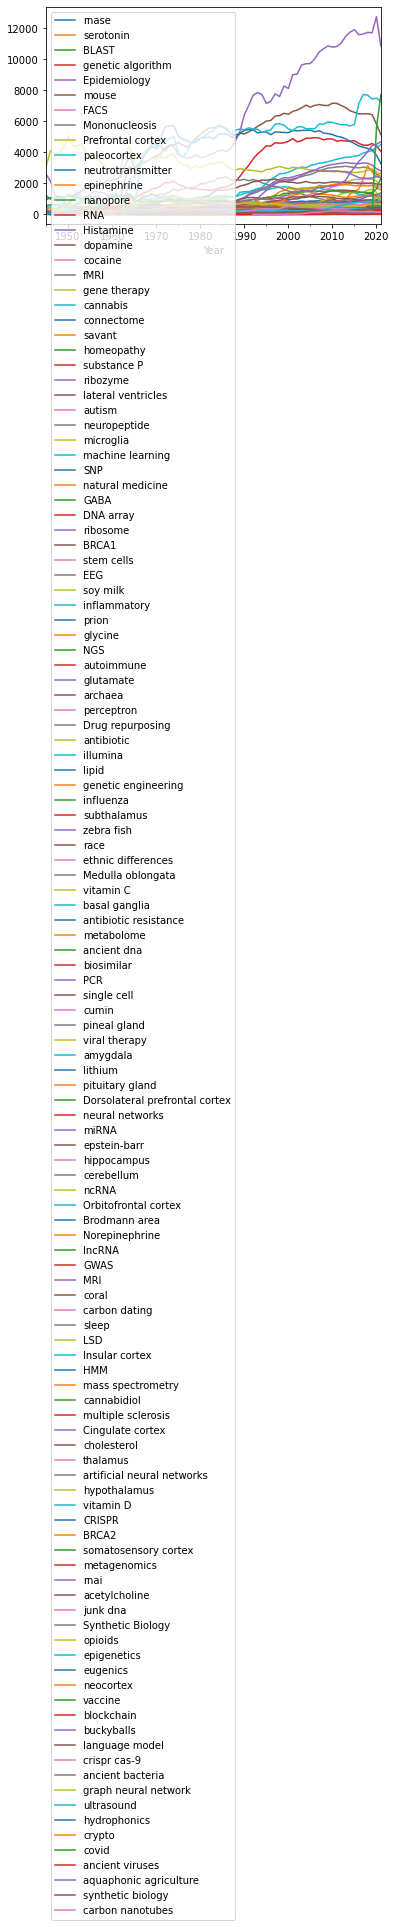

In [30]:
df.plot()

### Distrib of changes (pct_change) -> 3 classes

### 1st order difference makesi t easier to see big changes
* Note major OOM between topics

In [31]:
# df.diff().plot()

In [32]:
# # df.apply(np.log1p).pct_change().plot();
# df.pct_change().plot();

<AxesSubplot:xlabel='Year'>

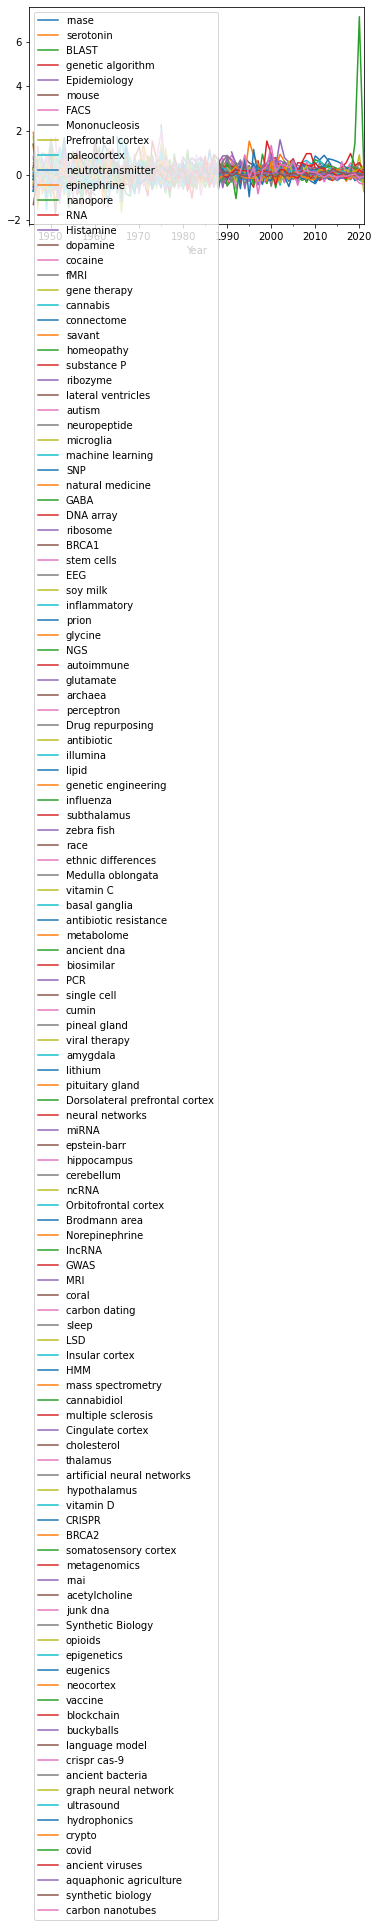

In [33]:
df.apply(np.log1p).diff().plot()

In [34]:
# df.apply(np.log1p).pct_change().clip(upper=2,lower=-2).plot()

To do corr properly, should do lag 1 or somesuch
* https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
* https://stackoverflow.com/questions/26083293/calculating-autocorrelation-of-pandas-dataframe-along-each-column

In [35]:
# df.corr().round(1)

In [36]:
def df_autocorr(df, lag=1, axis=0):
    """Compute full-sample column-wise autocorrelation for a DataFrame.
    https://stackoverflow.com/questions/26083293/calculating-autocorrelation-of-pandas-dataframe-along-each-column"""
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

df_autocorr(df) ## this is series with itself...


rnase                     0.971650
serotonin                 0.982834
BLAST                     0.981101
genetic algorithm         0.994244
Epidemiology              0.992874
                            ...   
covid                     0.770470
ancient viruses           0.963045
aquaphonic agriculture    0.997473
synthetic biology         0.992246
carbon nanotubes          0.982312
Length: 127, dtype: float64

In [37]:
df.drop(columns=["prion"]).corrwith(df["prion"].shift(1))

rnase                    -0.353498
serotonin                 0.050022
BLAST                     0.620833
genetic algorithm         0.774698
Epidemiology              0.866402
                            ...   
covid                    -0.208683
ancient viruses           0.841523
aquaphonic agriculture    0.607772
synthetic biology         0.539154
carbon nanotubes          0.356424
Length: 126, dtype: float64

In [38]:
np.corrcoef(df['miRNA'][1:-1], df['miRNA'][2:])

array([[nan, nan],
       [nan, nan]])

### melt/reshape / wide to long
+- add ratio, per series
* Keep `df_mat_raw`, `df_raw` as time series cols of all series , raw values. May be overly noisy without filtering... 

* New: add merge/join of raw review values as well (hope key is the same..)

In [39]:
df_rev_long = df_rev.melt(ignore_index=False).reset_index()
df_rev_long["variable"] = df_rev_long["variable"].str.split(" AND",expand=True)[0]
df_rev_long.rename(columns={"value":"reviews"},inplace=True)
print(df_rev_long["variable"].nunique(),"# terms")
df_rev_long

127 # terms


,Year,variable,reviews
0,1945-01-01,metabolome,0.000000
1,1946-01-01,metabolome,0.000000
2,1947-01-01,metabolome,0.000000
3,1948-01-01,metabolome,0.000000
4,1949-01-01,metabolome,0.000000
...,...,...,...
9774,2017-01-01,aquaphonic agriculture,257.229941
9775,2018-01-01,aquaphonic agriculture,277.559431
9776,2019-01-01,aquaphonic agriculture,294.638220
9777,2020-01-01,aquaphonic agriculture,358.107980


In [40]:
df = df.melt(ignore_index=False).reset_index()
# df.dropna(axis=0,inplace=True) ## don't drop na rows yet - what about 0s in between!
print(df["variable"].nunique(),"# terms")
df

127 # terms


,Year,variable,value
0,1945-01-01,rnase,14.624872
1,1946-01-01,rnase,14.833494
2,1947-01-01,rnase,6.149116
3,1948-01-01,rnase,14.132877
4,1949-01-01,rnase,4.775093
...,...,...,...
9774,2017-01-01,carbon nanotubes,168.085536
9775,2018-01-01,carbon nanotubes,169.052197
9776,2019-01-01,carbon nanotubes,175.652426
9777,2020-01-01,carbon nanotubes,154.682072


In [41]:
assert df["variable"].nunique() == df_rev_long["variable"].nunique()

In [42]:
# df.merge(df_rev_long,on=["variable"],how="inner")["variable"].nunique() ## all terms matched

In [43]:
s1 = df.shape[0]
df = df.merge(df_rev_long,on=["Year","variable"],how="left")
assert s1 == df.shape[0]
df

,Year,variable,value,reviews
0,1945-01-01,rnase,14.624872,0.000000
1,1946-01-01,rnase,14.833494,0.000000
2,1947-01-01,rnase,6.149116,0.000000
3,1948-01-01,rnase,14.132877,0.000000
4,1949-01-01,rnase,4.775093,0.000000
...,...,...,...,...
9774,2017-01-01,carbon nanotubes,168.085536,13.041780
9775,2018-01-01,carbon nanotubes,169.052197,14.359075
9776,2019-01-01,carbon nanotubes,175.652426,15.403149
9777,2020-01-01,carbon nanotubes,154.682072,13.900566


### pct change distrib (for target)
* Lots of noise on min end, due to cases of a target appearing once then going to 0? 
* We'll look at this later in the pipe after filtering for the targets

Target: percent change at: -, +- 0.03 (percent), +

In [44]:
# df["value"].dropna(axis=0).pct_change().describe() 
df.groupby("variable")["value"].pct_change().clip(upper=3).describe()

count    8357.000000
mean        0.121441
std         0.483041
min        -0.971698
25%        -0.045141
50%         0.009441
75%         0.126702
max         3.000000
Name: value, dtype: float64

<AxesSubplot:>

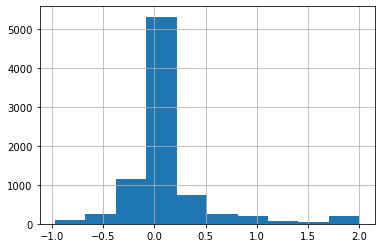

In [45]:
df.groupby("variable")["value"].pct_change().clip(upper=2).hist()

### keep TS context of targets and review ratio feats (for ts context)
* OLD - Is replace/FIX, later in script

In [46]:
df = df.merge(df_diff,on=["Year","variable"],how="left")
df = df.merge(df_ratio,on=["Year","variable"],how="left")

df["pct_diff"] = df.groupby("variable")["value"].pct_change(1)

In [47]:
df

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff
0,1945-01-01,rnase,14.624872,0.000000,14.624872,1.000000,NaN
1,1946-01-01,rnase,14.833494,0.000000,14.833494,1.000000,0.014265
2,1947-01-01,rnase,6.149116,0.000000,6.149116,1.000000,-0.585457
3,1948-01-01,rnase,14.132877,0.000000,14.132877,1.000000,1.298359
4,1949-01-01,rnase,4.775093,0.000000,4.775093,1.000000,-0.662129
...,...,...,...,...,...,...,...
9774,2017-01-01,carbon nanotubes,168.085536,13.041780,-89.144405,-0.530351,-0.063047
9775,2018-01-01,carbon nanotubes,169.052197,14.359075,-108.507234,-0.641856,0.005751
9776,2019-01-01,carbon nanotubes,175.652426,15.403149,-118.985794,-0.677393,0.039043
9777,2020-01-01,carbon nanotubes,154.682072,13.900566,-203.425908,-1.315123,-0.119386


##### Merge with patents
* check patent format matches

* at least some unmatched terms have no patent results from patentview, e.g.aquaphonic agriculture (Surprising!) 
https://datatool.patentsview.org/#search&pat=1|aquaphonic,1|agriculture 

* most terms match ok (note the MESH terms don't match that well (keywords messed up and split in some cases), but they aren't targets normally anyway, see beow)



non-matched in patents:

 ['paleocortex', 'savant', 'substance P', 'ethnic differences', 'vitamin C', 'vitamin D', 'eugenics', 'crispr cas-9', 'ancient viruses', 'aquaphonic agriculture']

In [48]:
mesh_terms_clean = df_mesh.columns.str.replace(r"[majr]","",regex=False)
print(len(mesh_terms_clean),"# mesh terms/col names, roughy")
mesh_terms_clean

### NOTE: some terms clearly misparsed, e.g. "' Access', ' and Evaluation'"

113 # mesh terms/col names, roughy


Index(['Embryonic Structures', 'Digestive System', 'Bacterial Structures',
       'Information Science', 'Human Activities', 'Support of Research',
       'Stomatognathic System', 'Biological Factors', 'Heterocyclic Compounds',
       'Cardiovascular Diseases',
       ...
       ' Access', ' and Evaluation',
       'Reproductive and Urinary Physiological Phenomena', 'Humanities',
       'Tissues', 'Genetic Phenomena', 'Viral Structures',
       'Musculoskeletal System', 'Plant Structures',
       'Cell Physiological Phenomena'],
      dtype='object', length=113)

In [49]:
# df_patents.loc[df_patents["variable"].str.contains("aqua",case=False)] ## 0 cases

In [50]:
## try joining patents -format of key may differ but seems ok
matched_terms = set(df.merge(df_patents,on=["Year","variable"],how="inner")["variable"].unique())
print("non-matched in patents:\n",[i for i in df["variable"].unique() if i not in matched_terms])
#### at least some unmatched terms have no patent results from patentview, e.g.aquaphonic agriculture (Surprising!) https://datatool.patentsview.org/#search&pat=1|aquaphonic,1|agriculture 
lst2 = [i for i in df_patents["variable"].unique() if i not in df["variable"].unique()]
## clean out mesh terms (not all parsed ok, but stil lreduces noise:
lst2 = [i for i in lst2 if i not in mesh_terms_clean]
print("patent, non-matched in terms:\n",lst2) ## results look like mesh terms - AKA matching is good!

# s1 = df.shape[0]
# df = df.merge(df_patents,on=["Year","variable"],how="left")
# assert s1 == df.shape[0]
# df

non-matched in patents:
 ['paleocortex', 'savant', 'substance P', 'ethnic differences', 'vitamin C', 'vitamin D', 'eugenics', 'crispr cas-9', 'ancient viruses', 'aquaphonic agriculture']
patent, non-matched in terms:
 ['Amino Acids, Peptides, and Proteins', 'Chemical Phenomena', 'Dentistry', 'Diagnosis', 'Education', 'Enzymes and Coenzymes', 'Food and Beverages', 'Fungal Structures', 'Integumentary System', 'Lipids', 'Mathematical Concepts', 'Nervous System Diseases', 'Nucleic Acids, Nucleotides, and Nucleosides', 'Nutritional and Metabolic Diseases', 'Pathological Conditions, Signs and Symptoms', 'Publication Components', 'Publication Formats', 'Social Sciences', 'Study Characteristics', 'Surgical Procedures, Operative', 'Technology, Industry, and Agriculture', 'Urogenital System', 'Wounds and Injuries']


In [51]:
df_patents[["Year","patent_yearly_total"]]

,Year,patent_yearly_total
0,1976-01-01,2936
1,1977-01-01,2674
2,1984-01-01,2445
3,1986-01-01,2608
4,1988-01-01,3082
...,...,...
5648,2012-01-01,16562
5649,2013-01-01,18098
5650,2017-01-01,21165
5651,2018-01-01,20638


In [52]:
df = df.merge(df_patents.drop(columns=["patent_yearly_total"]),on=["Year","variable"],how="left")
df["patent_count"] = df["patent_count"].fillna(0)
df["patent_frac"] = df["patent_frac"].fillna(0)

df = df.merge(df_patents[["Year","patent_yearly_total"]].drop_duplicates(),on=["Year"],how="left")
df["patent_yearly_total"] = df["patent_yearly_total"].fillna(0)
df

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total
0,1945-01-01,rnase,14.624872,0.000000,14.624872,1.000000,NaN,0.0,0.000000,0.0
1,1946-01-01,rnase,14.833494,0.000000,14.833494,1.000000,0.014265,0.0,0.000000,0.0
2,1947-01-01,rnase,6.149116,0.000000,6.149116,1.000000,-0.585457,0.0,0.000000,0.0
3,1948-01-01,rnase,14.132877,0.000000,14.132877,1.000000,1.298359,0.0,0.000000,0.0
4,1949-01-01,rnase,4.775093,0.000000,4.775093,1.000000,-0.662129,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
9774,2017-01-01,carbon nanotubes,168.085536,13.041780,-89.144405,-0.530351,-0.063047,281.0,1.327664,21165.0
9775,2018-01-01,carbon nanotubes,169.052197,14.359075,-108.507234,-0.641856,0.005751,267.0,1.293730,20638.0
9776,2019-01-01,carbon nanotubes,175.652426,15.403149,-118.985794,-0.677393,0.039043,256.0,1.066933,23994.0
9777,2020-01-01,carbon nanotubes,154.682072,13.900566,-203.425908,-1.315123,-0.119386,248.0,0.958158,25883.0


Sort

In [53]:
df.sort_values(["variable","Year"],inplace=True)
df

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total
154,1945-01-01,BLAST,34.124701,0.000000,34.124701,1.000000,NaN,0.0,0.000000,0.0
155,1946-01-01,BLAST,48.208856,0.000000,48.208856,1.000000,0.412726,0.0,0.000000,0.0
156,1947-01-01,BLAST,26.133743,0.000000,26.133743,1.000000,-0.457906,0.0,0.000000,0.0
157,1948-01-01,BLAST,39.572056,0.000000,39.572056,1.000000,0.514213,0.0,0.000000,0.0
158,1949-01-01,BLAST,20.692070,0.000000,20.692070,1.000000,-0.477104,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
4230,2017-01-01,zebra fish,260.232406,23.866788,79.581541,0.305809,-0.015689,1.0,0.004725,21165.0
4231,2018-01-01,zebra fish,273.093289,21.401596,112.507004,0.411973,0.049421,1.0,0.004845,20638.0
4232,2019-01-01,zebra fish,287.765903,23.282490,138.417245,0.481006,0.053727,0.0,0.000000,23994.0
4233,2020-01-01,zebra fish,273.329289,22.397988,125.342585,0.458577,-0.050168,1.0,0.003864,25883.0


In [54]:
df = df.round(4)

In [55]:
df_raw = df.copy()

df_raw["diff_lag5"] = df_raw["value"].sub(df_raw.groupby("variable")["value"].shift(5))
df_raw["pct_diff_lag5"] = df_raw.groupby("variable")["pct_diff"].shift(5)

df_raw

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,diff_lag5,pct_diff_lag5
154,1945-01-01,BLAST,34.1247,0.0000,34.1247,1.0000,NaN,0.0,0.0000,0.0,NaN,NaN
155,1946-01-01,BLAST,48.2089,0.0000,48.2089,1.0000,0.4127,0.0,0.0000,0.0,NaN,NaN
156,1947-01-01,BLAST,26.1337,0.0000,26.1337,1.0000,-0.4579,0.0,0.0000,0.0,NaN,NaN
157,1948-01-01,BLAST,39.5721,0.0000,39.5721,1.0000,0.5142,0.0,0.0000,0.0,NaN,NaN
158,1949-01-01,BLAST,20.6921,0.0000,20.6921,1.0000,-0.4771,0.0,0.0000,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4230,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,35.9295,-0.0164
4231,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,33.9943,0.0660
4232,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,52.3180,-0.0153
4233,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,34.9107,0.0126


In [56]:
# df_raw.head(8)

### Add lag features + missings + ratios
* Filter for rows which aren't surrounded by missing. 
###### Warning! May miss cases of very sparse/rare targets.. 

In [57]:
df["lag1"] = df.groupby("variable")["value"].shift(1) 
df["lag2"] = df.groupby("variable")["value"].shift(2) 
df["lag3"] = df.groupby("variable")["value"].shift(3) 
df["lag4"] = df.groupby("variable")["value"].shift(4) 
df["lag5"] = df.groupby("variable")["value"].shift(5)
df["lag6"] = df.groupby("variable")["value"].shift(6)

## future, leak
# df["future_lag1"] = df.groupby("variable")["value"].shift(-1)

## count current and past occurrences
# df["nans"] = df.drop(columns=["future_lag1"],axis=1).isna().sum(axis=1) 
## V1:
# df["non_nan"] = df.drop(columns=["future_lag1"],axis=1,errors="ignore").select_dtypes("number").notna().sum(axis=1)
# df["non_nan"] = df[["value","lag1","lag2"]].notna().sum(axis=1) ## Last used
df["non_nan"] = df[["lag1","lag2","lag3","lag4","lag5","lag6"]].notna().sum(axis=1) ## ALT, new, min 4 times
## need to fillna 0 for target? 
df

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,lag1,lag2,lag3,lag4,lag5,lag6,non_nan
154,1945-01-01,BLAST,34.1247,0.0000,34.1247,1.0000,NaN,0.0,0.0000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
155,1946-01-01,BLAST,48.2089,0.0000,48.2089,1.0000,0.4127,0.0,0.0000,0.0,34.1247,NaN,NaN,NaN,NaN,NaN,1
156,1947-01-01,BLAST,26.1337,0.0000,26.1337,1.0000,-0.4579,0.0,0.0000,0.0,48.2089,34.1247,NaN,NaN,NaN,NaN,2
157,1948-01-01,BLAST,39.5721,0.0000,39.5721,1.0000,0.5142,0.0,0.0000,0.0,26.1337,48.2089,34.1247,NaN,NaN,NaN,3
158,1949-01-01,BLAST,20.6921,0.0000,20.6921,1.0000,-0.4771,0.0,0.0000,0.0,39.5721,26.1337,48.2089,34.1247,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,264.3801,238.4186,235.4479,239.0990,224.3029,228.0463,6
4231,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,260.2324,264.3801,238.4186,235.4479,239.0990,224.3029,6
4232,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,273.0933,260.2324,264.3801,238.4186,235.4479,239.0990,6
4233,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,287.7659,273.0933,260.2324,264.3801,238.4186,235.4479,6


### keep cases with at least K occurences > 0
* at least 4 cases over past 5 years?  (+- count current)

Taking `prion` as an example: first discussed in ~1959-60s 
* https://pubmed.ncbi.nlm.nih.gov/?term=prion&filter=years.1956-1966
* Do we want to keep first occurrence? 


* Some terms lack occurences - drop them? 


##### Filter training (not context!) data to be after start point.  
* Keep also first occurence, as datetime interaction feature

In [58]:
# df = df.loc[df["nans"]<3]
# df = df.loc[(df["non_nan"]>2) & df["value"]>0] # PREV
# df = df.loc[df["non_nan"]>=5]
df["first"] = df.loc[df["value"]>0].groupby("variable")["Year"].transform("first")
# df["start"] = df["non_nan"]>=5
df["start"] = df.loc[df["non_nan"]>=5].groupby("variable")["Year"].transform("first")
print(df.variable.value_counts())
df

BLAST                     77
lateral ventricles        77
natural medicine          77
nanopore                  77
multiple sclerosis        77
                          ..
archaea                   77
aquaphonic agriculture    77
antibiotic resistance     77
antibiotic                77
zebra fish                77
Name: variable, Length: 127, dtype: int64


,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,lag1,lag2,lag3,lag4,lag5,lag6,non_nan,first,start
154,1945-01-01,BLAST,34.1247,0.0000,34.1247,1.0000,NaN,0.0,0.0000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1945-01-01,NaT
155,1946-01-01,BLAST,48.2089,0.0000,48.2089,1.0000,0.4127,0.0,0.0000,0.0,34.1247,NaN,NaN,NaN,NaN,NaN,1,1945-01-01,NaT
156,1947-01-01,BLAST,26.1337,0.0000,26.1337,1.0000,-0.4579,0.0,0.0000,0.0,48.2089,34.1247,NaN,NaN,NaN,NaN,2,1945-01-01,NaT
157,1948-01-01,BLAST,39.5721,0.0000,39.5721,1.0000,0.5142,0.0,0.0000,0.0,26.1337,48.2089,34.1247,NaN,NaN,NaN,3,1945-01-01,NaT
158,1949-01-01,BLAST,20.6921,0.0000,20.6921,1.0000,-0.4771,0.0,0.0000,0.0,39.5721,26.1337,48.2089,34.1247,NaN,NaN,4,1945-01-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,264.3801,238.4186,235.4479,239.0990,224.3029,228.0463,6,1948-01-01,1953-01-01
4231,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,260.2324,264.3801,238.4186,235.4479,239.0990,224.3029,6,1948-01-01,1953-01-01
4232,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,273.0933,260.2324,264.3801,238.4186,235.4479,239.0990,6,1948-01-01,1953-01-01
4233,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,287.7659,273.0933,260.2324,264.3801,238.4186,235.4479,6,1948-01-01,1953-01-01


In [59]:
print(df.shape[0])
t1 = df.variable.nunique()
df = df.loc[df["Year"]>= df["start"]]

print(t1 - df.variable.nunique(),"terms lost") # 1 term
# assert t1 == df.variable.nunique()

## fill missings with 0.  (do we need to check that years aren't skipped? )
df["value"] = df["value"].fillna(0)
print(df.shape[0])

9779
1 terms lost
7158


C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\472720529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].fillna(0)


In [60]:
df_raw["review_research_ratio_2"] = df_raw["reviews"].div(df_raw["value"])
df_raw["review_research_diff_2"] = df_raw["reviews"].sub(df_raw["value"])
df_raw["pat_div_research"] = df_raw["patent_count"].div(df_raw["value"])

In [61]:
df_raw.columns

Index(['Year', 'variable', 'value', 'reviews', 'research_review_diff',
       'research_review_ratio', 'pct_diff', 'patent_count', 'patent_frac',
       'patent_yearly_total', 'diff_lag5', 'pct_diff_lag5',
       'review_research_ratio_2', 'review_research_diff_2',
       'pat_div_research'],
      dtype='object')

In [62]:
df_raw.head(12)

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,diff_lag5,pct_diff_lag5,review_research_ratio_2,review_research_diff_2,pat_div_research
154,1945-01-01,BLAST,34.1247,0.0,34.1247,1.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,-34.1247,0.0
155,1946-01-01,BLAST,48.2089,0.0,48.2089,1.0,0.4127,0.0,0.0,0.0,NaN,NaN,0.0,-48.2089,0.0
156,1947-01-01,BLAST,26.1337,0.0,26.1337,1.0,-0.4579,0.0,0.0,0.0,NaN,NaN,0.0,-26.1337,0.0
157,1948-01-01,BLAST,39.5721,0.0,39.5721,1.0,0.5142,0.0,0.0,0.0,NaN,NaN,0.0,-39.5721,0.0
158,1949-01-01,BLAST,20.6921,0.0,20.6921,1.0,-0.4771,0.0,0.0,0.0,NaN,NaN,0.0,-20.6921,0.0
159,1950-01-01,BLAST,17.4841,0.0,17.4841,1.0,-0.1550,0.0,0.0,0.0,-16.6406,NaN,0.0,-17.4841,0.0
160,1951-01-01,BLAST,16.3743,0.0,16.3743,1.0,-0.0635,0.0,0.0,0.0,-31.8346,0.4127,0.0,-16.3743,0.0
161,1952-01-01,BLAST,26.8067,0.0,26.8067,1.0,0.6371,0.0,0.0,0.0,0.6730,-0.4579,0.0,-26.8067,0.0
162,1953-01-01,BLAST,19.2795,0.0,19.2795,1.0,-0.2808,0.0,0.0,0.0,-20.2926,0.5142,0.0,-19.2795,0.0
163,1954-01-01,BLAST,17.9343,0.0,17.9343,1.0,-0.0698,0.0,0.0,0.0,-2.7578,-0.4771,0.0,-17.9343,0.0


In [63]:
df["review_research_ratio_2"] = df["reviews"].div(df["value"])
df["review_research_diff_2"] = df["reviews"].sub(df["value"])
df["pat_div_research"] = df["patent_count"].div(df["value"])

C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\2163725334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_research_ratio_2"] = df["reviews"].div(df["value"])
C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\2163725334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_research_diff_2"] = df["reviews"].sub(df["value"])
C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\2163725334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [64]:
df.head(12)

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,lag3,lag4,lag5,lag6,non_nan,first,start,review_research_ratio_2,review_research_diff_2,pat_div_research
159,1950-01-01,BLAST,17.4841,0.0,17.4841,1.0,-0.1550,0.0,0.0,0.0,...,26.1337,48.2089,34.1247,NaN,5,1945-01-01,1950-01-01,0.0,-17.4841,0.0
160,1951-01-01,BLAST,16.3743,0.0,16.3743,1.0,-0.0635,0.0,0.0,0.0,...,39.5721,26.1337,48.2089,34.1247,6,1945-01-01,1950-01-01,0.0,-16.3743,0.0
161,1952-01-01,BLAST,26.8067,0.0,26.8067,1.0,0.6371,0.0,0.0,0.0,...,20.6921,39.5721,26.1337,48.2089,6,1945-01-01,1950-01-01,0.0,-26.8067,0.0
162,1953-01-01,BLAST,19.2795,0.0,19.2795,1.0,-0.2808,0.0,0.0,0.0,...,17.4841,20.6921,39.5721,26.1337,6,1945-01-01,1950-01-01,0.0,-19.2795,0.0
163,1954-01-01,BLAST,17.9343,0.0,17.9343,1.0,-0.0698,0.0,0.0,0.0,...,16.3743,17.4841,20.6921,39.5721,6,1945-01-01,1950-01-01,0.0,-17.9343,0.0
164,1955-01-01,BLAST,21.1861,0.0,21.1861,1.0,0.1813,0.0,0.0,0.0,...,26.8067,16.3743,17.4841,20.6921,6,1945-01-01,1950-01-01,0.0,-21.1861,0.0
165,1956-01-01,BLAST,18.6888,0.0,18.6888,1.0,-0.1179,0.0,0.0,0.0,...,19.2795,26.8067,16.3743,17.4841,6,1945-01-01,1950-01-01,0.0,-18.6888,0.0
166,1957-01-01,BLAST,11.6562,0.0,11.6562,1.0,-0.3763,0.0,0.0,0.0,...,17.9343,19.2795,26.8067,16.3743,6,1945-01-01,1950-01-01,0.0,-11.6562,0.0
167,1958-01-01,BLAST,7.3080,0.0,7.3080,1.0,-0.3730,0.0,0.0,0.0,...,21.1861,17.9343,19.2795,26.8067,6,1945-01-01,1950-01-01,0.0,-7.3080,0.0
168,1959-01-01,BLAST,11.8182,0.0,11.8182,1.0,0.6172,0.0,0.0,0.0,...,18.6888,21.1861,17.9343,19.2795,6,1945-01-01,1950-01-01,0.0,-11.8182,0.0


In [65]:
df.tail(12)

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,lag3,lag4,lag5,lag6,non_nan,first,start,review_research_ratio_2,review_research_diff_2,pat_div_research
4223,2010-01-01,zebra fish,202.8600,19.4262,72.7154,0.3585,0.0296,0.0,0.0000,14639.0,...,175.8077,165.8713,153.9140,176.7867,6,1948-01-01,1953-01-01,0.095762,-183.4338,0.000000
4224,2011-01-01,zebra fish,228.0463,20.9720,101.4301,0.4448,0.1242,0.0,0.0000,14975.0,...,188.9917,175.8077,165.8713,153.9140,6,1948-01-01,1953-01-01,0.091964,-207.0743,0.000000
4225,2012-01-01,zebra fish,224.3029,20.5580,100.9547,0.4501,-0.0164,1.0,0.0060,16562.0,...,197.0263,188.9917,175.8077,165.8713,6,1948-01-01,1953-01-01,0.091653,-203.7449,0.004458
4226,2013-01-01,zebra fish,239.0990,20.0046,105.9376,0.4431,0.0660,1.0,0.0055,18098.0,...,202.8600,197.0263,188.9917,175.8077,6,1948-01-01,1953-01-01,0.083667,-219.0944,0.004182
4227,2014-01-01,zebra fish,235.4479,22.0681,88.0233,0.3739,-0.0153,0.0,0.0000,19662.0,...,228.0463,202.8600,197.0263,188.9917,6,1948-01-01,1953-01-01,0.093728,-213.3798,0.000000
4228,2015-01-01,zebra fish,238.4186,20.7563,79.4464,0.3332,0.0126,0.0,0.0000,19640.0,...,224.3029,228.0463,202.8600,197.0263,6,1948-01-01,1953-01-01,0.087058,-217.6623,0.000000
4229,2016-01-01,zebra fish,264.3801,24.0558,96.9238,0.3666,0.1089,0.0,0.0000,19578.0,...,239.0990,224.3029,228.0463,202.8600,6,1948-01-01,1953-01-01,0.090989,-240.3243,0.000000
4230,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,...,235.4479,239.0990,224.3029,228.0463,6,1948-01-01,1953-01-01,0.091713,-236.3656,0.003843
4231,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,...,238.4186,235.4479,239.0990,224.3029,6,1948-01-01,1953-01-01,0.078367,-251.6917,0.003662
4232,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,...,264.3801,238.4186,235.4479,239.0990,6,1948-01-01,1953-01-01,0.080908,-264.4834,0.000000


<AxesSubplot:xlabel='Year'>

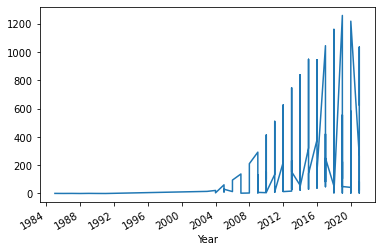

In [66]:
### https://stackoverflow.com/questions/13167391/filtering-grouped-dataframe-in-pandas
df.set_index("Year").groupby("variable").filter(lambda x: len(x) < 21)["value"].plot()

### pct_Change v2:

In [67]:
df.groupby("variable")["value"].pct_change()

159          NaN
160    -0.063475
161     0.637120
162    -0.280795
163    -0.069774
          ...   
4230   -0.015688
4231    0.049421
4232    0.053727
4233   -0.050168
4234   -0.026535
Name: value, Length: 7158, dtype: float64

In [68]:
# df.groupby("variable")["value"].dropna(axis=0).pct_change().clip(upper=10).describe() # error
df.groupby("variable")["value"].pct_change().describe()

count    6989.000000
mean        0.099108
std              NaN
min        -1.000000
25%        -0.046549
50%         0.016960
75%         0.121656
max        11.818140
Name: value, dtype: float64

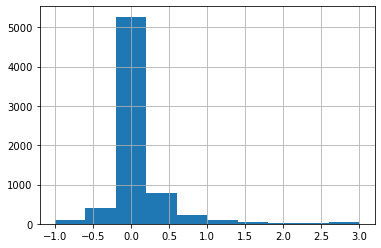

In [69]:
# df.groupby("variable")["value"].dropna(axis=0).pct_change().hist();
df.groupby("variable")["value"].pct_change().clip(upper=3).hist();

### Add differenced target 
###### Rename orig variable target col for consistency

In [70]:
df_patents["Year"].min()

Timestamp('1976-01-01 00:00:00')

In [71]:
df = df.drop(["non_nan"],axis=1,errors="ignore")
df["year_num"] = df["Year"].dt.year
df.fillna(0,inplace=True)

In [72]:
df = df.round(4)

In [73]:
df["y_diff"] = df.groupby("variable")["value"].diff(1) ## 1st order diff, per group
df["y_pct_diff"] = df.groupby("variable")["value"].pct_change(1) ## % change diff, per group
df.fillna(0,inplace=True)

# df["diff_lag1"] = df.groupby("variable")["y_diff"].shift(1)
# df["diff_lag5"] = df.groupby("variable")["y_diff"].shift(5) #ORIG
df["diff_lag5"] = df["value"].sub(df["lag5"])
df["diff_lag6"] = df["value"].sub(df["lag6"])

# df["pct_diff_lag1"] = df.groupby("variable")["y_pct_diff"].shift(1)
# df["pct_diff_lag4"] = df.groupby("variable")["y_pct_diff"].shift(4)
df["pct_diff_lag5"] = df.groupby("variable")["y_pct_diff"].shift(5)
df["pct_diff_lag6"] = df.groupby("variable")["y_pct_diff"].shift(6)
df.rename(columns={"value":"y_raw"},inplace=True)
df

,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,review_research_ratio_2,review_research_diff_2,pat_div_research,year_num,y_diff,y_pct_diff,diff_lag5,diff_lag6,pct_diff_lag5,pct_diff_lag6
159,1950-01-01,BLAST,17.4841,0.0000,17.4841,1.0000,-0.1550,0.0,0.0000,0.0,...,0.0000,-17.4841,0.0000,1950,0.0000,0.000000,-16.6406,17.4841,NaN,NaN
160,1951-01-01,BLAST,16.3743,0.0000,16.3743,1.0000,-0.0635,0.0,0.0000,0.0,...,0.0000,-16.3743,0.0000,1951,-1.1098,-0.063475,-31.8346,-17.7504,NaN,NaN
161,1952-01-01,BLAST,26.8067,0.0000,26.8067,1.0000,0.6371,0.0,0.0000,0.0,...,0.0000,-26.8067,0.0000,1952,10.4324,0.637120,0.6730,-21.4022,NaN,NaN
162,1953-01-01,BLAST,19.2795,0.0000,19.2795,1.0000,-0.2808,0.0,0.0000,0.0,...,0.0000,-19.2795,0.0000,1953,-7.5272,-0.280795,-20.2926,-6.8542,NaN,NaN
163,1954-01-01,BLAST,17.9343,0.0000,17.9343,1.0000,-0.0698,0.0,0.0000,0.0,...,0.0000,-17.9343,0.0000,1954,-1.3452,-0.069774,-2.7578,-21.6378,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,...,0.0917,-236.3656,0.0038,2017,-4.1477,-0.015688,35.9295,32.1861,-0.016415,0.124156
4231,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,...,0.0784,-251.6917,0.0037,2018,12.8609,0.049421,33.9943,48.7904,0.065965,-0.016415
4232,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,...,0.0809,-264.4834,0.0000,2019,14.6726,0.053727,52.3180,48.6669,-0.015270,0.065965
4233,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,...,0.0819,-250.9313,0.0037,2020,-14.4366,-0.050168,34.9107,37.8814,0.012617,-0.015270


In [74]:
# ### make features lag, to allow easily using as time series context
# df["research_review_ratio_lag1"] = df.groupby("variable")["research_review_ratio"].shift(1)
# df["research_review_diff_lag1"] = df.groupby("variable")["research_review_diff"].shift(1)

# df.drop(columns=["research_review_ratio","research_review_diff"],axis=1,errors="ignore",inplace=True)
# df

### Filter Year:
## drop partial and corona year +- patent? 


* current patents data is from 1976 onwards

In [75]:
##ORIG: df = df.loc[df["year_num"]<2020]
df = df.loc[df["year_num"]<=2020] ## maybe keep 2021?  (Is data sufficiently up todate?)

# ## patents data is from 1976 onwards relevant, maybe take from there and on? 
# df = df.loc[df["year_num"]>1976]
print(df.shape[0])

7033


In [76]:
df["y_pct_diff"].describe()

count    7033.000000
mean        0.099255
std         0.469736
min        -1.000000
25%        -0.043066
50%         0.015361
75%         0.119181
max        11.818140
Name: y_pct_diff, dtype: float64

<AxesSubplot:>

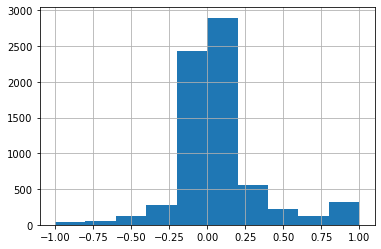

In [77]:
df["y_pct_diff"].clip(upper=1).hist()

* Trend

In [78]:
df[['y_raw','pct_diff','y_diff']].corrwith(df["year_num"])

y_raw       0.134170
pct_diff   -0.117007
y_diff     -0.018584
dtype: float64

In [79]:
df["y_pct_bins"] = pd.cut(df["y_pct_diff"],bins=[-20,-0.04,0.05,20])
df["y_pct_bins"]

C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\308339491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pct_bins"] = pd.cut(df["y_pct_diff"],bins=[-20,-0.04,0.05,20])


159      (-0.04, 0.05]
160     (-20.0, -0.04]
161       (0.05, 20.0]
162     (-20.0, -0.04]
163     (-20.0, -0.04]
             ...      
4229      (0.05, 20.0]
4230     (-0.04, 0.05]
4231     (-0.04, 0.05]
4232      (0.05, 20.0]
4233    (-20.0, -0.04]
Name: y_pct_bins, Length: 7033, dtype: category
Categories (3, interval[float64, right]): [(-20.0, -0.04] < (-0.04, 0.05] < (0.05, 20.0]]

In [80]:
df["y_pct_bins"].value_counts()

(0.05, 20.0]      2708
(-0.04, 0.05]     2484
(-20.0, -0.04]    1841
Name: y_pct_bins, dtype: int64

### note that targets ranges over 2 OOM

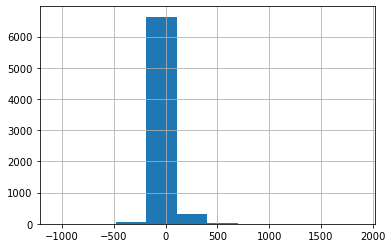

In [81]:
# df["y_diff"].describe()
df["y_diff"].hist();

In [82]:
df.groupby("variable")[["y_diff","y_raw"]].mean().round(1).sort_values(by=["y_raw"],ascending=False)

,y_diff,y_raw
variable,,
Epidemiology,173.7,5886.2
mouse,72.9,4674.0
ultrasound,102.4,4347.6
lipid,36.2,4314.2
antibiotic,-32.5,3204.8
...,...,...
cumin,0.2,2.9
crispr cas-9,-0.0,2.8
savant,0.0,1.6


In [83]:
df[df["y_diff"]==0]

,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,review_research_diff_2,pat_div_research,year_num,y_diff,y_pct_diff,diff_lag5,diff_lag6,pct_diff_lag5,pct_diff_lag6,y_pct_bins
159,1950-01-01,BLAST,17.4841,0.0000,17.4841,1.0000,-0.1550,0.0,0.0000,0.0,...,-17.4841,0.0000,1950,0.0,0.0,-16.6406,17.4841,NaN,NaN,"(-0.04, 0.05]"
2748,1998-01-01,BRCA1,76.4652,15.3773,-28.2268,-0.3691,0.2215,7.0,0.0610,11472.0,...,-61.0879,0.0915,1998,0.0,0.0,68.9810,76.4652,NaN,NaN,"(-0.04, 0.05]"
7830,1998-01-01,BRCA2,45.7106,12.0069,-44.8680,-0.9816,0.3739,1.0,0.0087,11472.0,...,-33.7037,0.0219,1998,0.0,0.0,44.7751,45.7106,NaN,NaN,"(-0.04, 0.05]"
6193,1978-01-01,Brodmann area,1.1006,0.0000,-5.1363,-4.6667,0.4429,0.0,0.0000,2469.0,...,-1.1006,0.0000,1978,0.0,0.0,1.1006,0.6618,NaN,NaN,"(-0.04, 0.05]"
7762,2007-01-01,CRISPR,2.1610,0.1271,-1279.2139,-591.9412,1.3153,0.0,0.0000,10622.0,...,-2.0339,0.0000,2007,0.0,0.0,1.9841,2.1610,NaN,NaN,"(-0.04, 0.05]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,1950-01-01,vaccine,1205.2406,0.0000,1205.2406,1.0000,0.1201,0.0,0.0000,0.0,...,-1205.2406,0.0000,1950,0.0,0.0,-8.6238,1205.2406,NaN,NaN,"(-0.04, 0.05]"
5243,1952-01-01,viral therapy,36.0504,0.0000,36.0504,1.0000,0.8714,0.0,0.0000,0.0,...,-36.0504,0.0000,1952,0.0,0.0,36.0504,32.3420,NaN,NaN,"(-0.04, 0.05]"
4471,1950-01-01,vitamin C,307.7210,0.0000,307.7210,1.0000,0.2803,0.0,0.0000,0.0,...,-307.7210,0.0000,1950,0.0,0.0,-238.2742,307.7210,NaN,NaN,"(-0.04, 0.05]"
7628,1950-01-01,vitamin D,166.6822,0.0000,166.6822,1.0000,0.2928,0.0,0.0000,0.0,...,-166.6822,0.0000,1950,0.0,0.0,-3.9413,166.6822,NaN,NaN,"(-0.04, 0.05]"


##### melt MESH data as possible target

In [84]:
df_mesh_flat = df_mesh.melt(ignore_index=False).reset_index()
df_mesh_flat["y_pct_diff"] = df_mesh_flat.groupby("variable")["value"].pct_change(1) ## % change diff, per group
df_mesh_flat.fillna(0,inplace=True)
df_mesh_flat["y_pct_bins"] = pd.cut(df_mesh_flat["y_pct_diff"],bins=[-20,-0.04,0.04,20])
df_mesh_flat["variable"] = df_mesh_flat["variable"].str.replace("[majr]","",regex=False)

df_mesh_flat = df_mesh_flat.merge(mesh_cat.drop(columns=["num"]),left_on="variable",right_on="mesh_name",how="left")
display(df_mesh_flat)

,Year,variable,value,y_pct_diff,y_pct_bins,mesh_id,mesh_name,mesh_tree_number
0,1945-01-01,Embryonic Structures,443.621118,0.000000,"(-0.04, 0.04]",D004628,Embryonic Structures,A16
1,1946-01-01,Embryonic Structures,684.194912,0.542296,"(0.04, 20.0]",D004628,Embryonic Structures,A16
2,1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",D004628,Embryonic Structures,A16
3,1948-01-01,Embryonic Structures,583.687833,-0.159980,"(-20.0, -0.04]",D004628,Embryonic Structures,A16
4,1949-01-01,Embryonic Structures,689.205106,0.180777,"(0.04, 20.0]",D004628,Embryonic Structures,A16
...,...,...,...,...,...,...,...,...
8696,2017-01-01,Cell Physiological Phenomena,3591.683000,-0.019350,"(-0.04, 0.04]",D002468,Cell Physiological Phenomena,G04
8697,2018-01-01,Cell Physiological Phenomena,3493.587695,-0.027312,"(-0.04, 0.04]",D002468,Cell Physiological Phenomena,G04
8698,2019-01-01,Cell Physiological Phenomena,3325.705005,-0.048055,"(-20.0, -0.04]",D002468,Cell Physiological Phenomena,G04
8699,2020-01-01,Cell Physiological Phenomena,2625.302588,-0.210603,"(-20.0, -0.04]",D002468,Cell Physiological Phenomena,G04


Cases of bad mesh name/url:

```['Pathological Conditions', ' Signs and Symptoms', 'Nucleic Acids',
       ' Nucleotides', ' and Nucleosides', 'Hormones',
       ' Hormone Substitutes', ' and Hormone Antagonists', 'Amino Acids',
       ' Peptides', ' and Proteins', 'Surgical Procedures', ' Operative',
       'Congenital', ' Hereditary',
       ' and Neonatal Diseases and Abnormalities',
       'Health Care Facilities', ' Manpower', ' and Services',
       'Technology', ' Industry', ' and Agriculture',
       'Health Care Quality', ' Access', ' and Evaluation']```

In [85]:
df_mesh_flat.loc[df_mesh_flat["mesh_name"].isna()].variable.unique()

array(['Pathological Conditions', ' Signs and Symptoms', 'Nucleic Acids',
       ' Nucleotides', ' and Nucleosides', 'Hormones',
       ' Hormone Substitutes', ' and Hormone Antagonists', 'Amino Acids',
       ' Peptides', ' and Proteins', 'Surgical Procedures', ' Operative',
       'Congenital', ' Hereditary',
       ' and Neonatal Diseases and Abnormalities',
       'Health Care Facilities', ' Manpower', ' and Services',
       'Technology', ' Industry', ' and Agriculture',
       'Health Care Quality', ' Access', ' and Evaluation'], dtype=object)

Mark/drop mesh cases with bad names / not joined ?
* What about amino acids, proteins... 

In [86]:
# df_mesh_flat.dropna(subset="mesh_name",axis=0,inplace=True)

In [87]:
df_mesh_flat.describe()

,value,y_pct_diff
count,8701.000000,8701.000000
mean,3132.395859,0.015055
std,3040.387924,0.348052
min,0.000000,-1.000000
25%,1088.426694,-0.032878
50%,2450.640926,0.000000
75%,4148.442729,0.036833
max,42575.411757,17.949364


In [88]:
df_mesh_flat2 = df_mesh_flat.dropna(subset=["mesh_name"],axis=0)
df_mesh_flat2.set_index("Year",inplace=True)
df_mesh_flat2 = df_mesh_flat2[['variable', 'value', 'y_pct_diff', 'y_pct_bins', 'mesh_tree_number']]
df_mesh_flat2

,variable,value,y_pct_diff,y_pct_bins,mesh_tree_number
Year,,,,,
1945-01-01,Embryonic Structures,443.621118,0.000000,"(-0.04, 0.04]",A16
1946-01-01,Embryonic Structures,684.194912,0.542296,"(0.04, 20.0]",A16
1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",A16
1948-01-01,Embryonic Structures,583.687833,-0.159980,"(-20.0, -0.04]",A16
1949-01-01,Embryonic Structures,689.205106,0.180777,"(0.04, 20.0]",A16
...,...,...,...,...,...
2017-01-01,Cell Physiological Phenomena,3591.683000,-0.019350,"(-0.04, 0.04]",G04
2018-01-01,Cell Physiological Phenomena,3493.587695,-0.027312,"(-0.04, 0.04]",G04
2019-01-01,Cell Physiological Phenomena,3325.705005,-0.048055,"(-20.0, -0.04]",G04


In [89]:
df_mesh_flat2["variable"].value_counts()

Embryonic Structures                     77
Digestive System                         77
Polycyclic Compounds                     77
Behavioral Disciplines and Activities    77
Persons                                  77
                                         ..
Respiratory System                       77
Neoplasms                                77
Animal Structures                        77
Complex Mixtures                         77
Cell Physiological Phenomena             77
Name: variable, Length: 88, dtype: int64

In [90]:
df_mesh_flat2["y_pct_diff"].describe().round(3)

count    6776.000
mean        0.017
std         0.380
min        -1.000
25%        -0.035
50%         0.000
75%         0.037
max        17.949
Name: y_pct_diff, dtype: float64

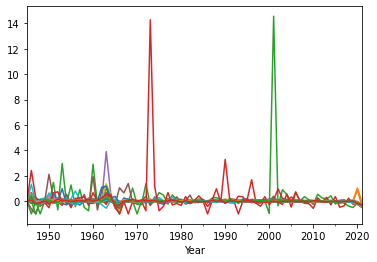

In [91]:
df_mesh_flat2.loc[df_mesh_flat2["mesh_tree_number"].str.startswith(("A","B","C"))].groupby("variable")["y_pct_diff"].plot();

# df_mesh_flat2.loc[df_mesh_flat2["mesh_tree_number"].str.startswith(("A","B","C"))][["variable","y_pct_diff"]].plot();

## merge+flat

In [92]:
df_mesh_flat = df_mesh_flat.merge(df_medline,on="Year")
df["year_num"] = df["Year"].dt.year
df_mesh_flat["total_value"] = df_mesh_flat["value"]*df_mesh_flat["Total Medline Cites"]
df_mesh_flat

C:\Users\Dan Ofer\AppData\Local\Temp\ipykernel_18244\1969330042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year_num"] = df["Year"].dt.year


,Year,variable,value,y_pct_diff,y_pct_bins,mesh_id,mesh_name,mesh_tree_number,Total Medline Cites,% US Citations,total_value
0,1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",D004628,Embryonic Structures,A16,62869,NaN,4.368453e+07
1,1947-01-01,Digestive System,4928.516526,0.012590,"(-0.04, 0.04]",D004064,Digestive System,A03,62869,NaN,3.098509e+08
2,1947-01-01,Bacterial Structures,0.000000,-1.000000,"(-20.0, -0.04]",D056226,Bacterial Structures,A20,62869,NaN,0.000000e+00
3,1947-01-01,Information Science,1165.257494,-0.175267,"(-20.0, -0.04]",D007254,Information Science,L01,62869,NaN,7.325857e+07
4,1947-01-01,Human Activities,699.461952,-0.103958,"(-20.0, -0.04]",D006802,Human Activities,I03,62869,NaN,4.397447e+07
...,...,...,...,...,...,...,...,...,...,...,...
8470,2021-01-01,Genetic Phenomena,345.803010,-0.268636,"(-20.0, -0.04]",D055614,Genetic Phenomena,G05,774026,35.0,2.676605e+08
8471,2021-01-01,Viral Structures,2417.386617,-0.277538,"(-20.0, -0.04]",D056224,Viral Structures,A21,774026,35.0,1.871120e+09
8472,2021-01-01,Musculoskeletal System,2341.575520,-0.335382,"(-20.0, -0.04]",D009141,Musculoskeletal System,A02,774026,35.0,1.812440e+09
8473,2021-01-01,Plant Structures,36.486927,-0.298265,"(-20.0, -0.04]",D018514,Plant Structures,A18,774026,35.0,2.824183e+07


In [93]:
df_raw = df_raw.merge(df_medline.fillna(0),on="Year",how="left")
df_raw["total_value"] = df_raw["value"]*df_raw["Total Medline Cites"]

# df_raw[['Total Medline Cites', '% US Citations', 'total_value']].fillna(0,inplace=True)
df_raw[['Total Medline Cites', '% US Citations', 'total_value']] = df_raw[['Total Medline Cites', '% US Citations', 'total_value']].fillna(0)
df_raw

,Year,variable,value,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,diff_lag5,pct_diff_lag5,review_research_ratio_2,review_research_diff_2,pat_div_research,Total Medline Cites,% US Citations,total_value
0,1945-01-01,BLAST,34.1247,0.0000,34.1247,1.0000,NaN,0.0,0.0000,0.0,NaN,NaN,0.000000,-34.1247,0.000000,0.0,0.0,0.000000e+00
1,1946-01-01,BLAST,48.2089,0.0000,48.2089,1.0000,0.4127,0.0,0.0000,0.0,NaN,NaN,0.000000,-48.2089,0.000000,0.0,0.0,0.000000e+00
2,1947-01-01,BLAST,26.1337,0.0000,26.1337,1.0000,-0.4579,0.0,0.0000,0.0,NaN,NaN,0.000000,-26.1337,0.000000,62869.0,0.0,1.643000e+06
3,1948-01-01,BLAST,39.5721,0.0000,39.5721,1.0000,0.5142,0.0,0.0000,0.0,NaN,NaN,0.000000,-39.5721,0.000000,68711.0,0.0,2.719039e+06
4,1949-01-01,BLAST,20.6921,0.0000,20.6921,1.0000,-0.4771,0.0,0.0000,0.0,NaN,NaN,0.000000,-20.6921,0.000000,60931.0,0.0,1.260790e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9774,2017-01-01,zebra fish,260.2324,23.8668,79.5815,0.3058,-0.0157,1.0,0.0047,21165.0,35.9295,-0.0164,0.091713,-236.3656,0.003843,848833.0,40.0,2.208938e+08
9775,2018-01-01,zebra fish,273.0933,21.4016,112.5070,0.4120,0.0494,1.0,0.0048,20638.0,33.9943,0.0660,0.078367,-251.6917,0.003662,866985.0,40.0,2.367678e+08
9776,2019-01-01,zebra fish,287.7659,23.2825,138.4172,0.4810,0.0537,0.0,0.0000,23994.0,52.3180,-0.0153,0.080908,-264.4834,0.000000,903184.0,38.0,2.599056e+08
9777,2020-01-01,zebra fish,273.3293,22.3980,125.3426,0.4586,-0.0502,1.0,0.0039,25883.0,34.9107,0.0126,0.081945,-250.9313,0.003659,986012.0,37.0,2.695060e+08


## Export

In [94]:
# df.to_csv("trends_v2.csv.gz",index=False,compression="gzip")
# df_raw.to_csv("all_trends_matrix_v2.csv.gz",index=True,compression="gzip")
if SAVE_OUTPUT:
    df.to_csv("trends_v6.csv.gz",index=False,compression="gzip")
    df_raw.to_csv("trends_context_v6.csv.gz",index=False,compression="gzip")
    # matrix of major mesh trends:
    df_mesh.to_csv("mesh_matrix_v5.csv.gz",index=True,compression="gzip") 
    df_mesh_flat.to_csv("mesh_majr_v5.csv.gz",index=False,compression="gzip") 

### naive baseline
* boolean target - predict majority class, proba

In [95]:
dummy = (df["y_pct_diff"].dropna()>0)
dummy.mean() ## 0.59 

0.5612114318214133

In [96]:
roc_auc_score(y_true=(df["y_pct_diff"].dropna()>0).astype(int),y_score=[0.59]*len(dummy)) 

0.5